# Dataset Description:

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes or not.
There are 8 features (explanatory variables) in the dataset to predict a patient has diabetes or not.

The variables in our dataset are:

•	Pregnancies: Number of times pregnant

•	Glucose: Plasma glucose concentration   in 2 hours in an oral glucose tolerance test

•	Blood Pressure: Diastolic blood pressure (mm Hg)

•	Skin Thickness: Triceps skin fold thickness (mm)

•	Insulin: 2-Hour serum insulin (mu U/ml)

•	BMI: Body mass index (weight in kg/(height in m)^2)

•	Diabetes Pedigree Function: Diabetes pedigree function

•	Age: Age (years)

•	Outcome: Class variable (0 or 1)


# Imports Libraries:

In [101]:
# ----------
import pandas as pd
import numpy as np
import warnings
from scipy import stats
# --------
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,StratifiedKFold
from imblearn.over_sampling  import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# -------
import  matplotlib.pyplot as plt
import seaborn as sns

# -------
import optuna
from optuna.integration import TFKerasPruningCallback
# ---------------
import tensorflow as tf
from tensorflow import keras  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
# -----
from imblearn.pipeline import Pipeline

# ------
import joblib

# Load Dataset:

In [45]:
data = pd.read_csv('diabetes.csv')
data.head(10)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   
5            5      116             74              0        0  25.6   
6            3       78             50             32       88  31.0   
7           10      115              0              0        0  35.3   
8            2      197             70             45      543  30.5   
9            8      125             96              0        0   0.0   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
5                     0.201   30        0  
6                     0.248   26        1  
7                     0.134   29        0  
8                     0.158   53        1  
9                     0.232   54        1

# EDA: Exploratory Data Analysis:

# Data description & informations:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
# Descriptions
data.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

The minimum values of some numeical features are zeor which is illogical in diabetes patients which need to be handle as a missing data.

# Data Cleaning and Preprocessing:

In [10]:
# Missing data
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

The data has no missing values.

In [9]:
# Attributes having zero values
data.iloc[:,1:-1].eq(0).sum()

Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

Although, dataset has no missing entries, but we should consider some 0 values as a missing data of  attributes such as 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI' beacuse as an healthy and living individulas, entries of these atributes can not be zeros.

Let us assume that all the entries belongs to living persons because we generally detect the daibates of living person only.

In [13]:
# Duplicate data checking:
print(f'Number of duplicate rows: {data.duplicated().sum()}')

Number of duplicate rows: 0


The dataset does not contain any duplicate rows.

In [14]:
# Outliers:

Before imputing missing data or illogical zeors, we need to inspect the outliers and it is also required for improve predictive power of the ML and DL models.

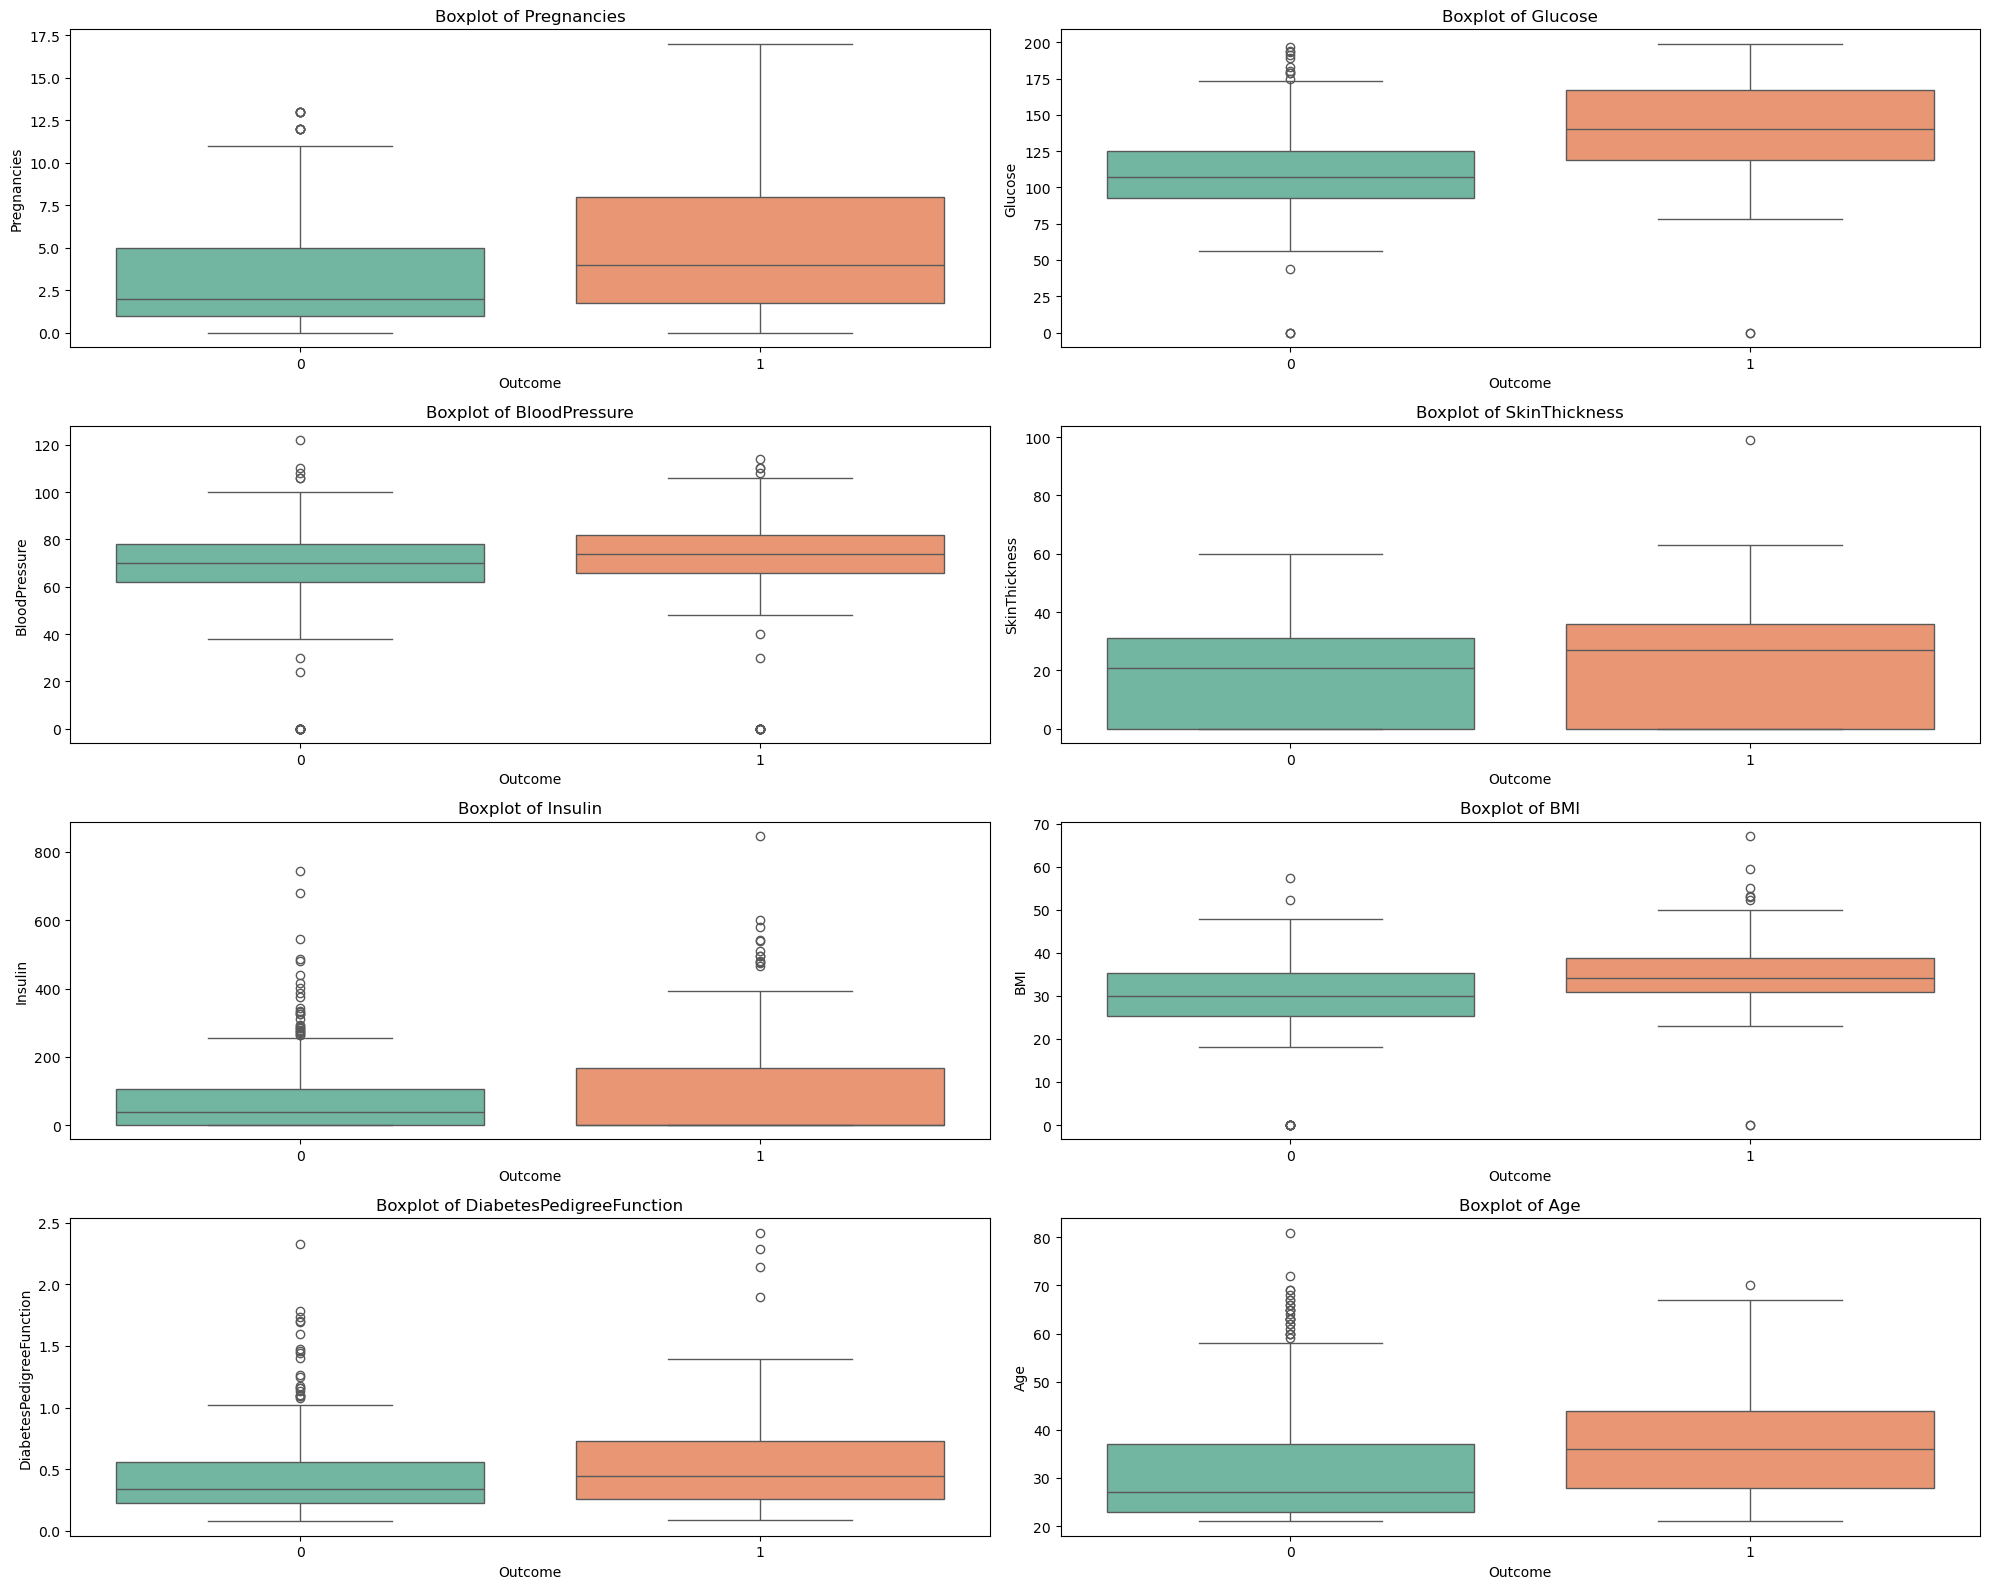

In [15]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 16))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# List of feature names
features = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'
]

# Generate boxplots for each feature
for i, feature in enumerate(features):
    sns.boxplot(x='Outcome', y=feature, data=data, ax=axes[i], palette='Set2')
    axes[i].set_title(f'Boxplot of {feature}')
    axes[i].set_xlabel('Outcome')
    axes[i].set_ylabel(feature)

# Adjust layout
plt.tight_layout()
plt.show()

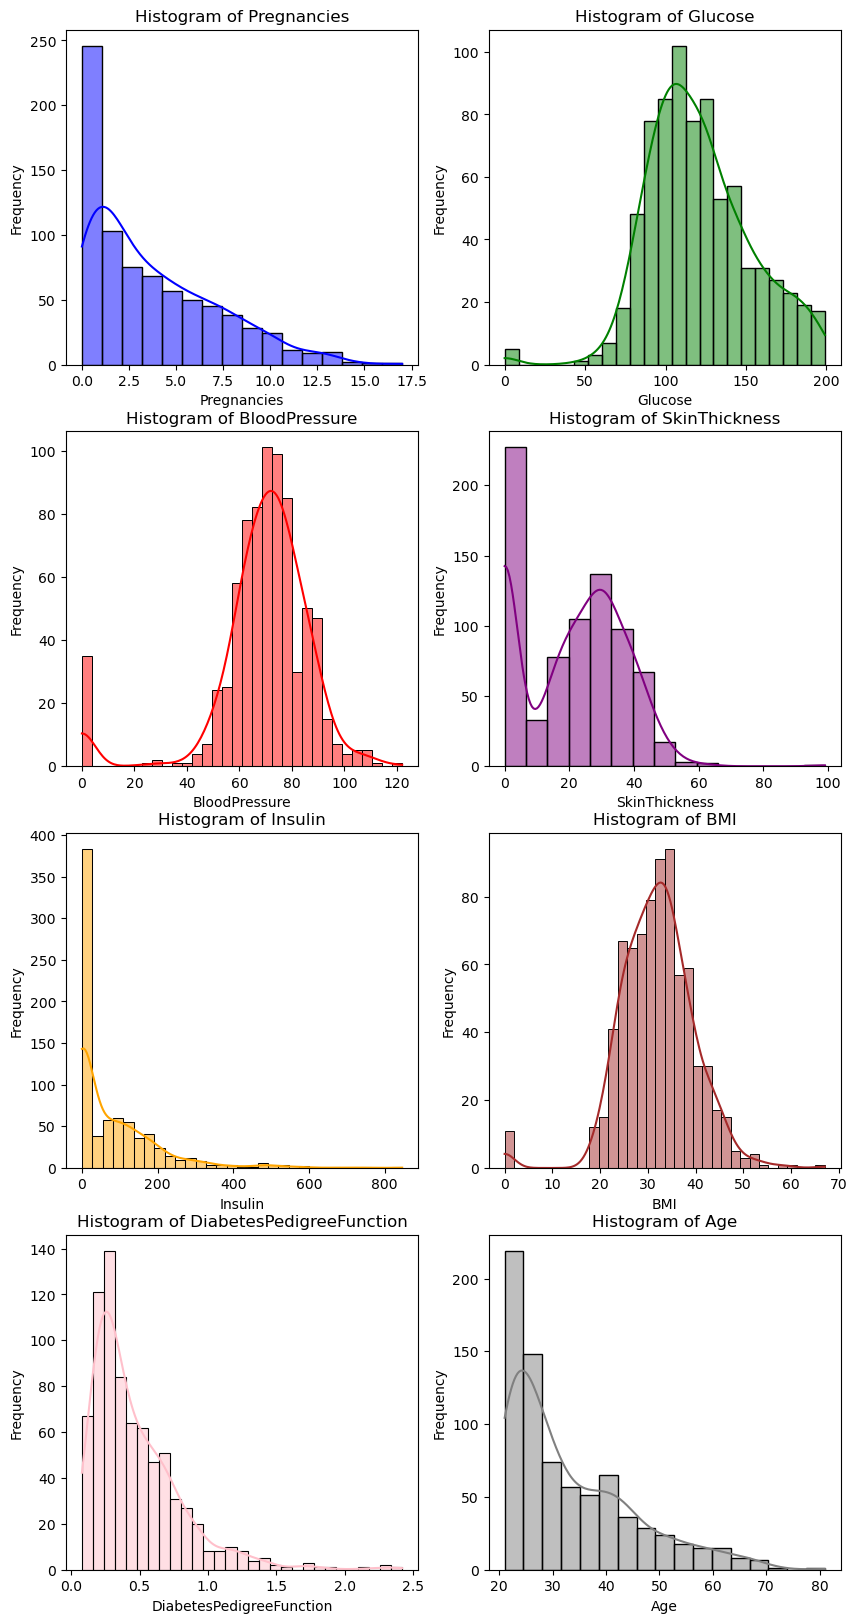

In [16]:
# Distribution of each featurers
# Define a list of colors to use for each histogram
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']
fig,axes = plt.subplots(4,2,figsize=(10,20))
ax = axes.flatten()
for i,col in enumerate(data.iloc[:,:-1].columns):
    sns.histplot(x=data[col],kde=True,color=colors[i],ax=ax[i])
    ax[i].set_title(f'Histogram of {col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Frequency')
plt.show()

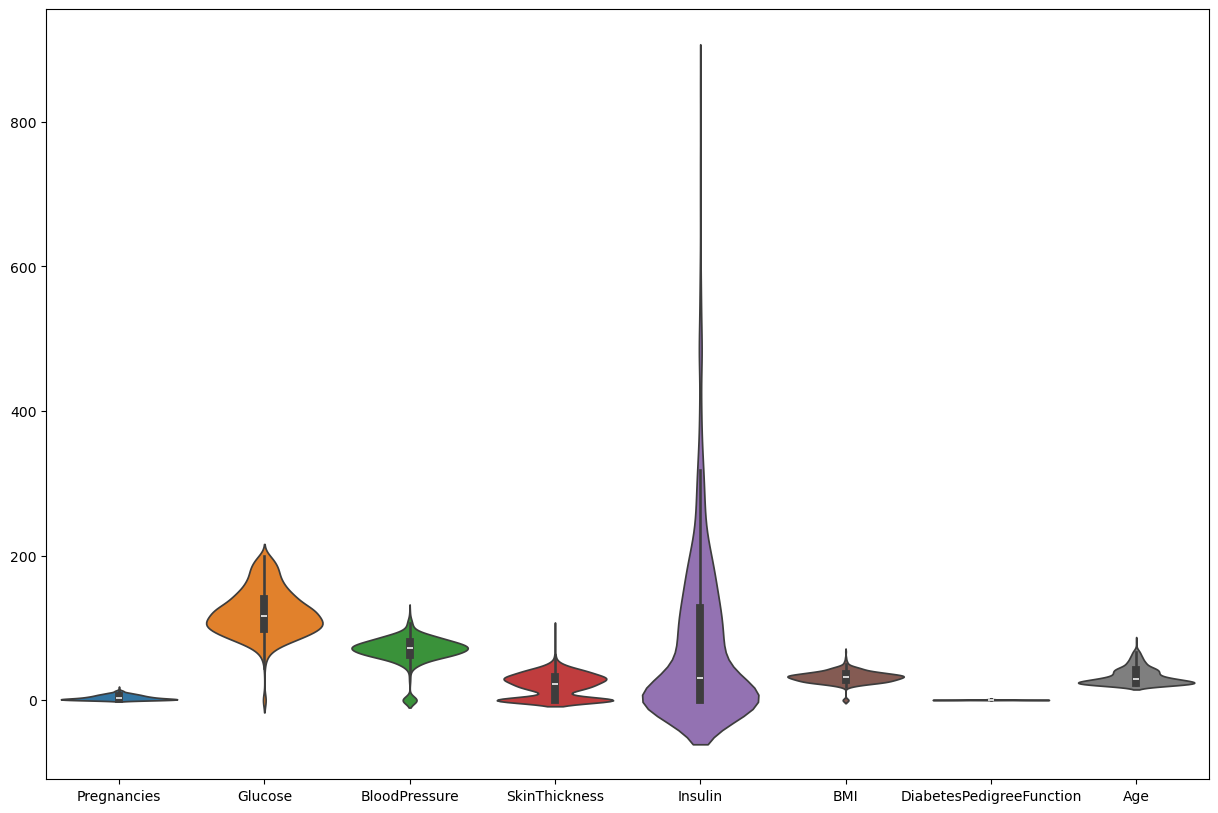

In [52]:
# Violin plots
plt.figure(figsize=(15,10))
sns.violinplot(data.iloc[:,:-1])
plt.show()

The above three types of plots ensure that every features contains outliers where insulin has more number of outliers.
Again, from the box plots we have seen that the non-diabetes patients entries has more outliers compare to diabetes patients. So, when we will fill missing data/garbage zeros, we need to fill it with respective class data.

### Missing/Illogical Zeros Filling:

In [76]:
data.eq(0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [80]:
data[data['Glucose']==0]['Outcome'].value_counts()

Outcome
0    3
1    2
Name: count, dtype: int64

Since our dataset contains outliers, so mean will not be correct imputed value, we will go with median ,due to its robustness against outliers.

In [3]:
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI']

# Replace zeros with NaN for easier imputation
data[columns_to_impute] = data[columns_to_impute].replace(0, np.nan)

# Initialize the Simple Imputer
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Impute for Outcome 0
data.loc[data['Outcome'] == 0, columns_to_impute] = median_imputer.fit_transform(data.loc[data['Outcome'] == 0, columns_to_impute])

# Re-initialize the Simple Imputer (optional, but good practice)
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Impute for Outcome 1
data.loc[data['Outcome'] == 1, columns_to_impute] = median_imputer.fit_transform(data.loc[data['Outcome'] == 1, columns_to_impute])

# Display the first 10 and last 10 rows of the DataFrame
display(data.head(10))
display(data.tail(10))


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0    169.5  33.6   
1            1     85.0           66.0           29.0    102.5  26.6   
2            8    183.0           64.0           32.0    169.5  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   
5            5    116.0           74.0           27.0    102.5  25.6   
6            3     78.0           50.0           32.0     88.0  31.0   
7           10    115.0           70.0           27.0    102.5  35.3   
8            2    197.0           70.0           45.0    543.0  30.5   
9            8    125.0           96.0           32.0    169.5  34.3   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
5                     0.201   30        0  
6                     0.248   26        1  
7                     0.134   29        0  
8                     0.158   53        1  
9                     0.232   54        1

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
758            1    106.0           76.0           27.0    102.5  37.5   
759            6    190.0           92.0           32.0    169.5  35.5   
760            2     88.0           58.0           26.0     16.0  28.4   
761            9    170.0           74.0           31.0    169.5  44.0   
762            9     89.0           62.0           27.0    102.5  22.5   
763           10    101.0           76.0           48.0    180.0  32.9   
764            2    122.0           70.0           27.0    102.5  36.8   
765            5    121.0           72.0           23.0    112.0  26.2   
766            1    126.0           60.0           32.0    169.5  30.1   
767            1     93.0           70.0           31.0    102.5  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
758                     0.197   26        0  
759                     0.278   66        1  
760                     0.766   22        0  
761                     0.403   43        1  
762                     0.142   33        0  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0

In [4]:
# Save the final data after imputeed illogical 0 values
data.to_csv('Imputed_Diabetes_Data.csv')

# EDA: Explratory Data Analysis:

### Data informations and Descrptions:

In [29]:
data = pd.read_csv('Imputed_Diabetes_Data.csv')
data.drop(columns=['Unnamed: 0'],inplace=True)
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0    169.5  33.6   
1            1     85.0           66.0           29.0    102.5  26.6   
2            8    183.0           64.0           32.0    169.5  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


The dataset contaions 768 dataentries with features 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'.
All  featutres has numeric data where outcome is binary entries , according to data information earlier.

In [31]:
# Data descriptions
data.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.677083      72.389323      29.089844  141.753906   
std       3.369578   30.464161      12.106039       8.890820   89.100847   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  102.500000   
50%       3.000000  117.000000      72.000000      28.000000  102.500000   
75%       6.000000  140.250000      80.000000      32.000000  169.500000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.434635                  0.471876   33.240885    0.348958  
std      6.880498                  0.331329   11.760232    0.476951  
min     18.200000                  0.078000   21.000000    0.000000  
25%     27.500000                  0.243750   24.000000    0.000000  
50%     32.050000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

Pregnancies: This feature indicates the number of times a patient has been pregnant. The values range from 0 to 17, with a mean of 3.85. This suggests that on average, patients have had about 4 pregnancies.

Glucose: This feature measures the plasma glucose concentration in a 2-hour oral glucose tolerance test. The values range from 44 to 199, with a mean of 121.69. This range reflects a wide spectrum of glucose metabolism levels among the patients, which is critical for diabetes prediction.

Blood Pressure: The diastolic blood pressure (measured in mm Hg) ranges from 24 to 122, with an average value of 72.41 mm Hg. This provides insight into the patients' cardiovascular health, which is relevant to diabetes risk.

Skin Thickness: This feature represents the triceps skin fold thickness, measured in millimeters. The values range from 7 to 99, with a mean of 29.15. This measurement is often used as an estimate of body fat.

Insulin: This feature captures the serum insulin levels (in μU/ml) two hours after a glucose tolerance test. The values range from 14 to 846, with an average level of 155.55. The wide range shows significant variability in insulin secretion, which is a critical factor for assessing diabetes risk.

BMI: The Body Mass Index (BMI) of the patients ranges from 18.2 to 67.1, with a mean of 32.46. BMI is an important metric for assessing overall health and obesity levels, which are risk factors for diabetes.

Diabetes Pedigree Function: This feature indicates a genetic predisposition to diabetes, with values ranging from 0.078 to 2.42 and an average of 0.47. A higher value suggests a stronger hereditary risk factor.

Age: The age of the patients ranges from 21 to 81 years, with an average age of 33.24. This represents the age distribution of the patients, which can also be a factor in the likelihood of developing diabetes.

Outcome: This binary feature indicates whether the patient has diabetes (1) or not (0). The average outcome value is 0.35, indicating that approximately 35% of the patients in the dataset have diabetes. This also suggests a class imbalance, with a larger proportion of patients without diabetes (65%).

### Data Visualizations:

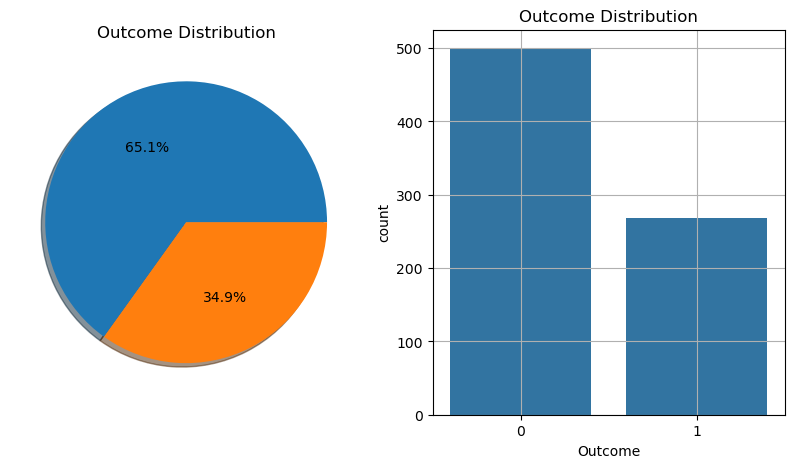

In [85]:
# Outcome count plot
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].pie(data['Outcome'].value_counts(),autopct='%1.1f%%',shadow=True)
axes[0].set_title('Outcome Distribution')
sns.countplot(x='Outcome',data = data,ax=axes[1])
axes[1].set_title('Outcome Distribution')
plt.grid(True)
plt.show()

Among the 768 patients, 65.1 % patients has no diabetes and 34.9% patients suffers in diabetes.

This information ensure that our dataset is class imbalanced dataset and it is needed to handle class imbalance during training process.

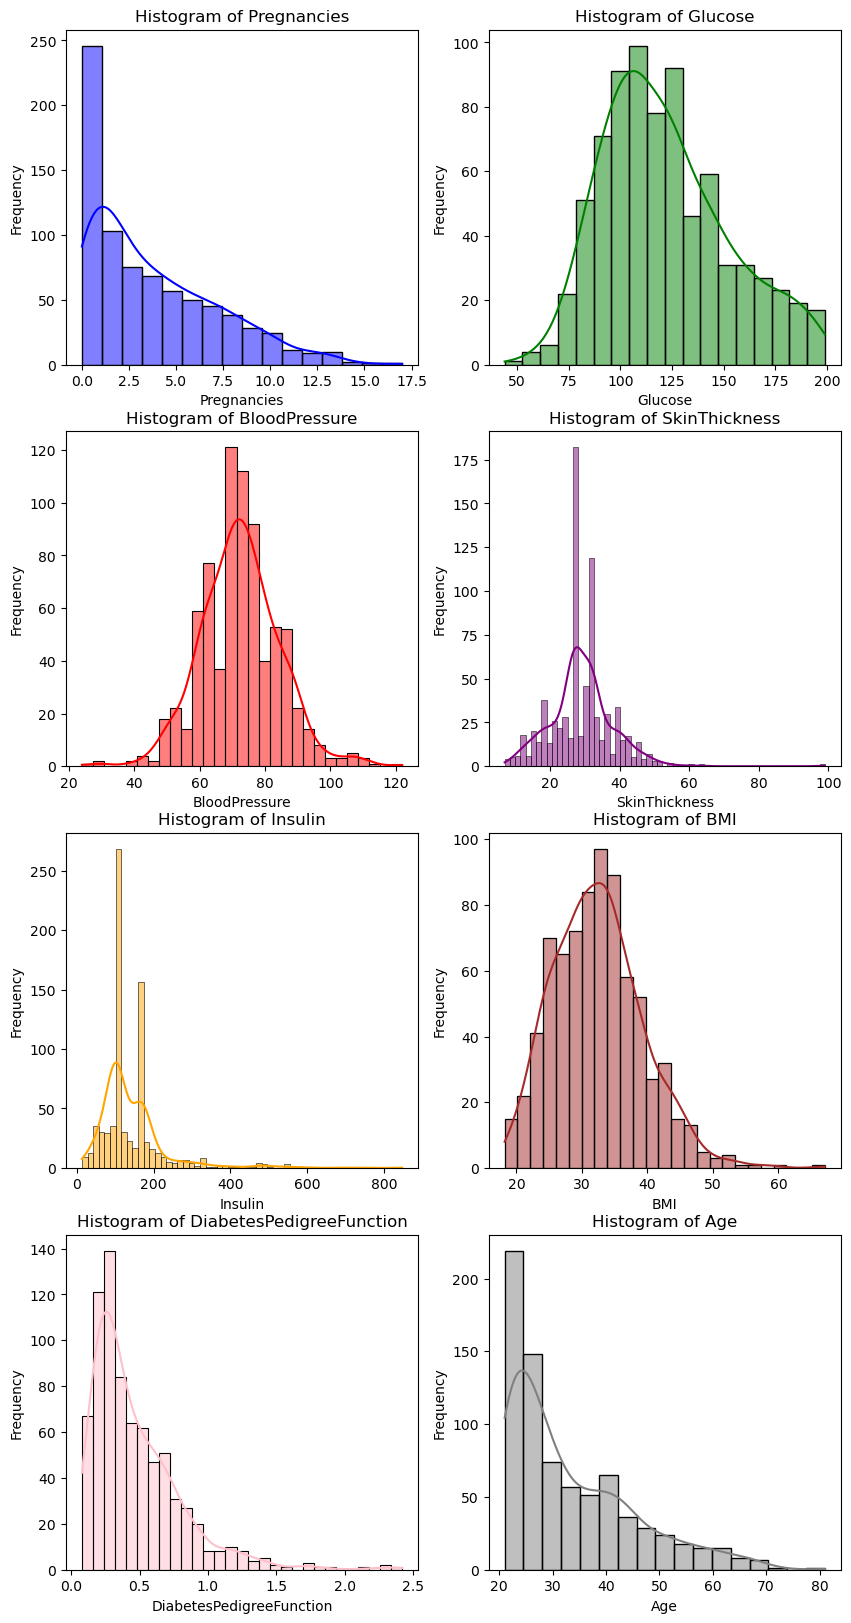

In [86]:
# Histograms of each features
# Define a list of colors to use for each histogram
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']
fig,axes = plt.subplots(4,2,figsize=(10,20))
ax = axes.flatten()
for i,col in enumerate(data.iloc[:,:-1].columns):
    sns.histplot(x=data[col],kde=True,color=colors[i],ax=ax[i])
    ax[i].set_title(f'Histogram of {col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Frequency')
plt.show()

The above hist plots shows that Glucose,Bloodpressure,SkinThickness,Insulin,BMI are normally distributed where as Pregnencies,DiabetesPedigreeFunction and Age are right skewed function.

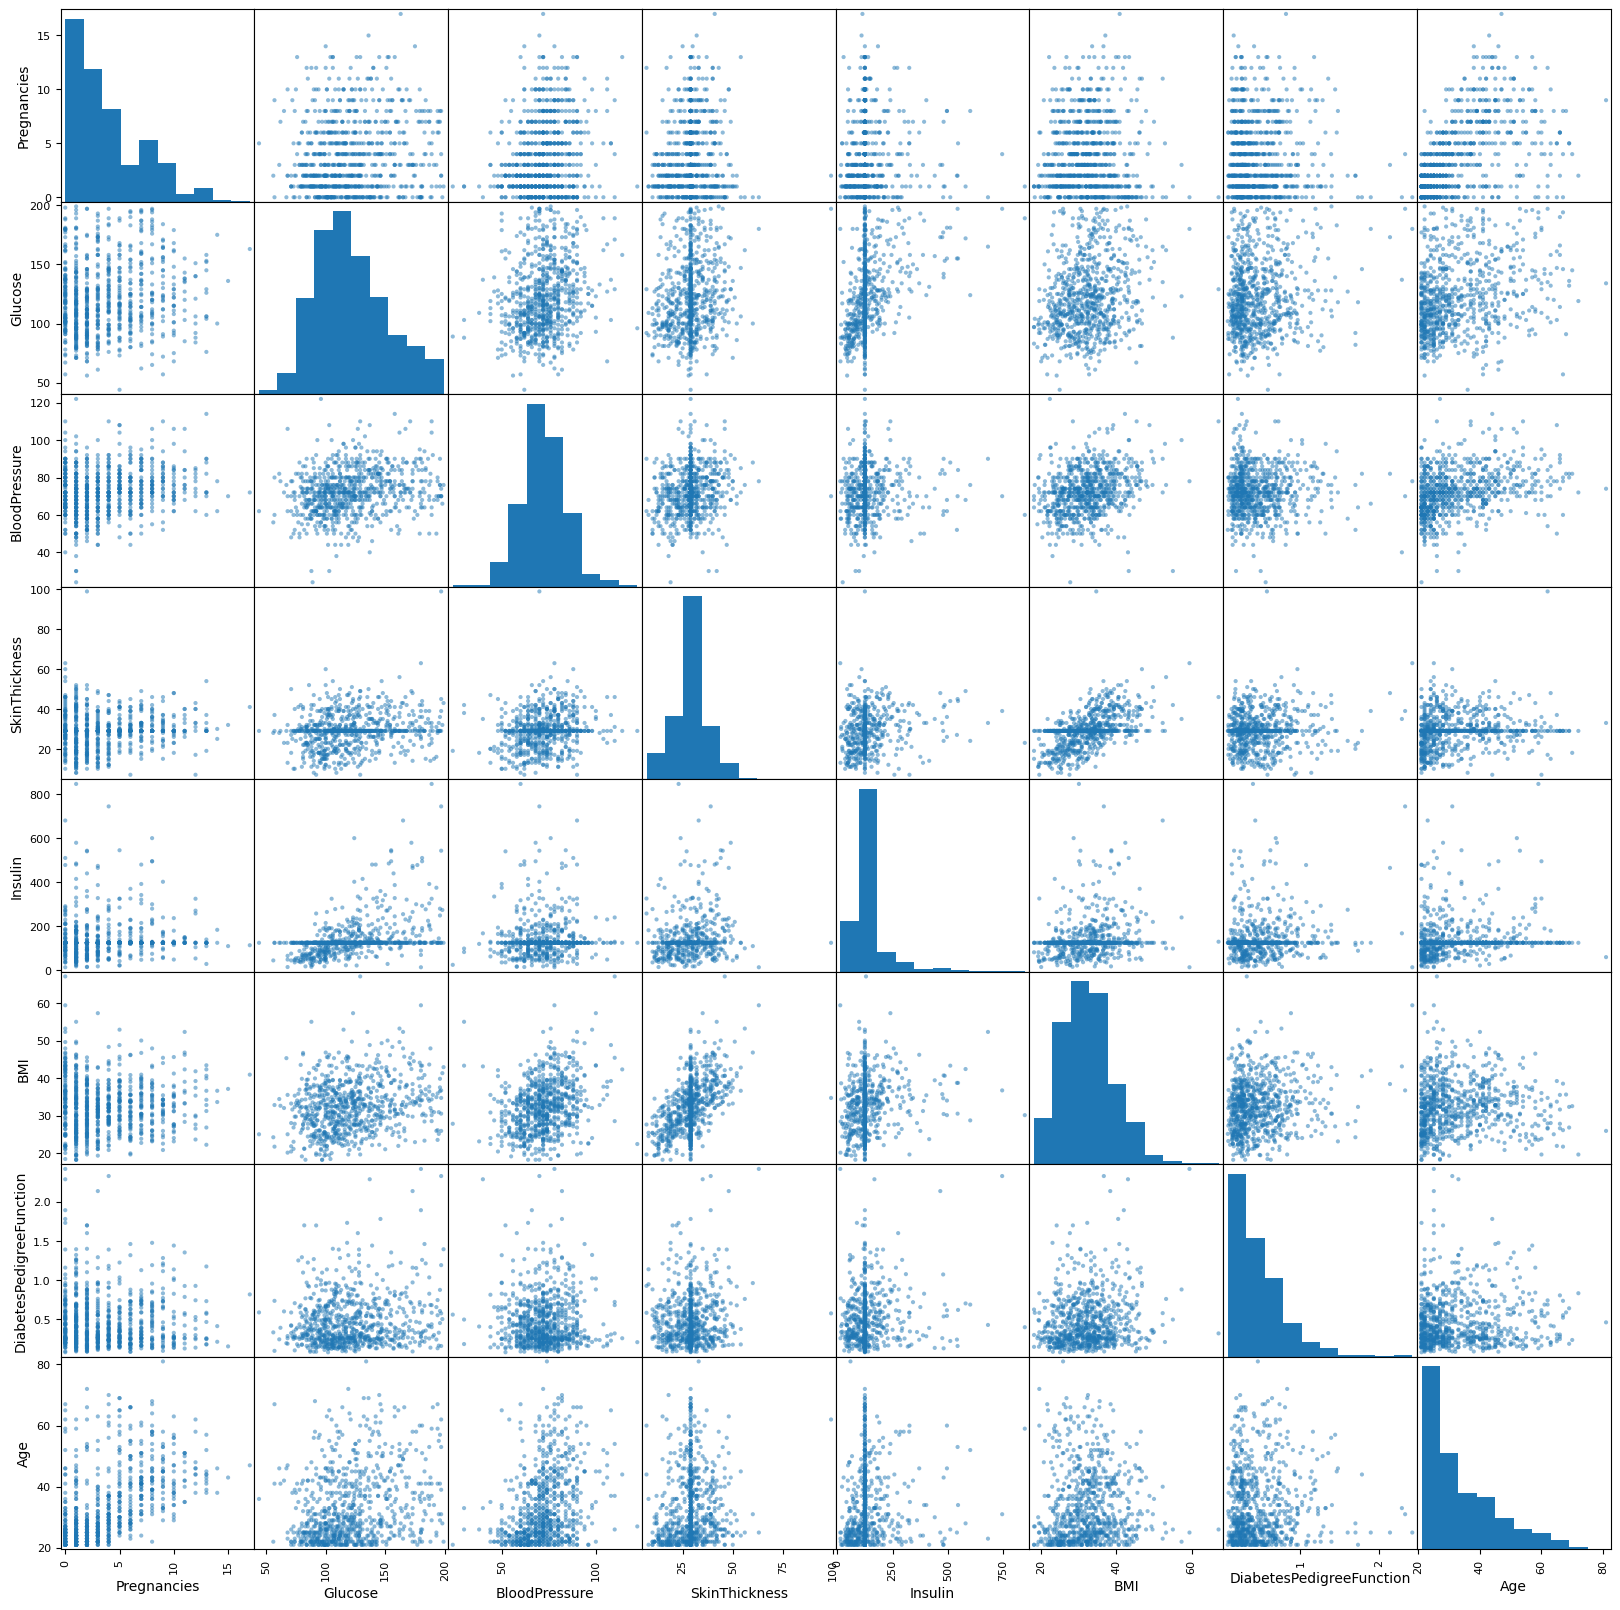

In [58]:
# Scatter plots matrix
from pandas.plotting import scatter_matrix
scatter_matrix(data.iloc[:,:-1],figsize=(20,20))
plt.show()

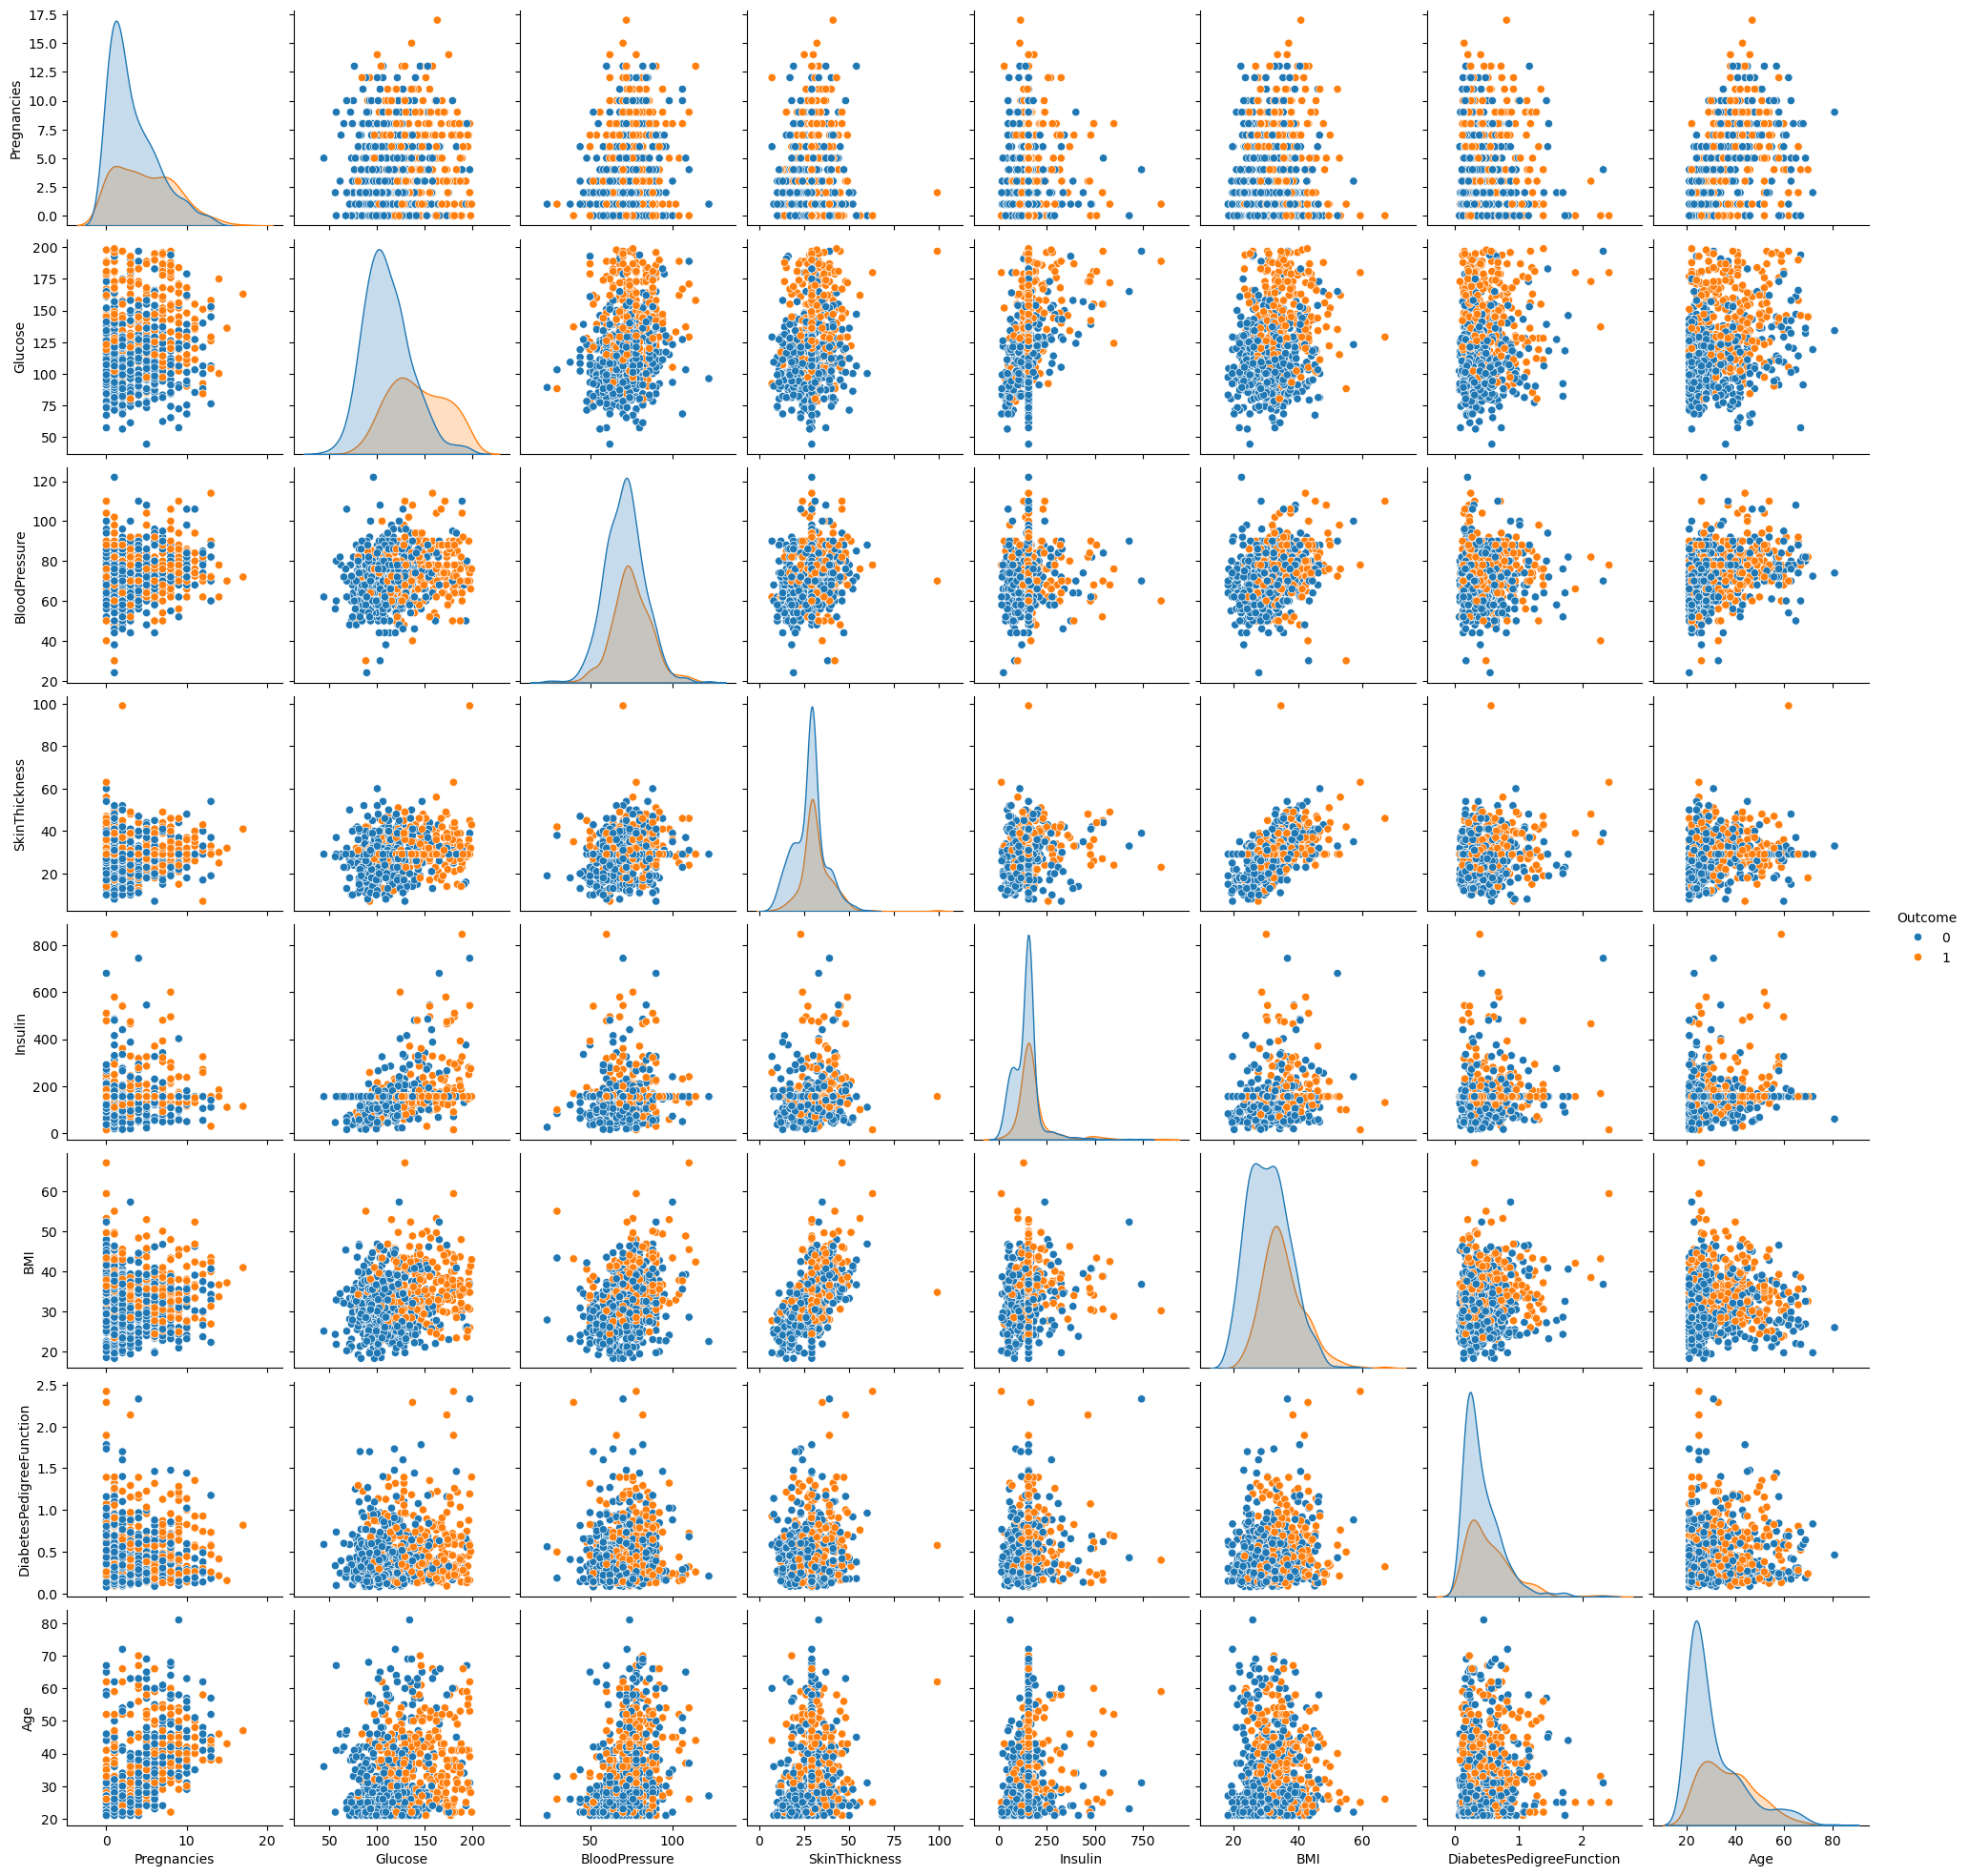

In [127]:
# Pairplots
sns.pairplot(data,hue='Outcome')
plt.show()

There is no linear relationship between the features ,except BMI and SkinThickness but not much strong linear.

# Distribution of each features baseed on 0 & 1 calss:

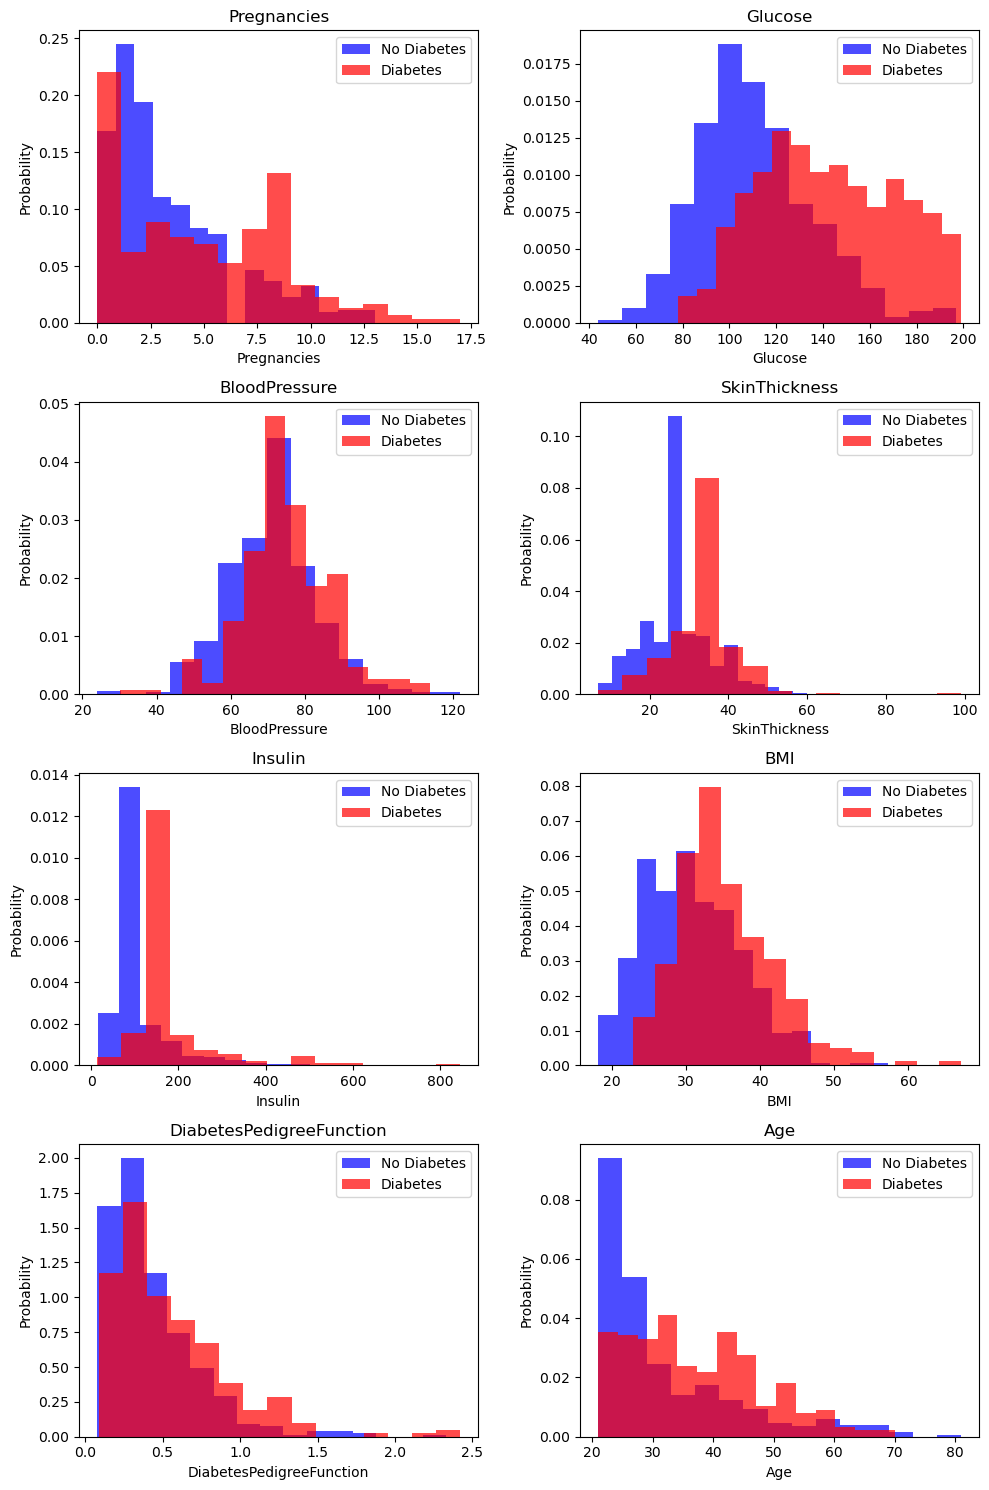

In [87]:
# Create a figure with the specified number of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for i in range(len(data.columns[:-1])):
    label = data.columns[i]
    ax = axes[i]
    ax.hist(data[data['Outcome']==0][label], color='blue', label="No Diabetes", alpha=0.7, density=True, bins=15)
    ax.hist(data[data['Outcome']==1][label], color='red', label="Diabetes", alpha=0.7, density=True, bins=15)
    ax.set_title(label)
    ax.set_xlabel(label)
    ax.set_ylabel("Probability")
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Pregnancy: The number of pregnancies does not seem to influence the likelihood of having diabetes but > 7 time pregnacy may cause diabetes.

Glucose Level: Individuals with glucose levels below 140 has a higher chance of having diabetes. Conversely, those with glucose levels above 120 generally have a lower chance of having diabetes.

Blood Pressure: Blood pressure levels, whether low or high, do not significantly impact diabetes risk. However, individuals with blood pressure in the range of [50, 90] show a higher chance of having diabetes.

Skin Thickness: Skin thickness does not significantly impact diabetes risk, but individuals with a skin thickness less than 30 mm have a higher chance of having diabetes.

2-Hour Insulin Level: Low insulin levels (below 150 µU/ml) are associated with a lower chance of having diabetes and above 150 has higher chance of diabetes.

BMI: BMI does not have a strong overall influence on diabetes risk, but a BMI below 30 is associated with a lower chance of having diabetes and > 30 with a higher chance of diabetes.

Diabetes Pedigree Function: The Diabetes Pedigree Function does not show a strong relationship with diabetes risk.

Age: Individuals under 30 have a lower chance of having diabetes, while older individuals (above 30) generally have a higher chance of having diabetes.


Hence, all of the above visulization plots it is confirmed that there are lot of outliers, we need to remove some of them , not all because of ditecting diabetes, these features are important in medical term and we remove the outliers which are far way from mean of the data values  of corresponding feature, based on pre-assigned thresold value.

# Outliers Removing::

### Using IQR rules:

In [32]:
# Function to calculate percentage of outliers using IQR
def calculate_outlier_percentage_iqr(data, features):
    outlier_percentages = {}
    for feature in features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
        outlier_percentage = (len(outliers) / len(data)) * 100
        
        outlier_percentages[feature] = outlier_percentage
    
    return outlier_percentages

# List of features
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Calculate percentage of outliers
outlier_percentages_iqr = calculate_outlier_percentage_iqr(data, features)
for feature, percentage in outlier_percentages_iqr.items():
    print(f"Percentage of outliers in {feature} using IQR method: {percentage:.2f}%")


Percentage of outliers in Pregnancies using IQR method: 0.52%
Percentage of outliers in Glucose using IQR method: 0.00%
Percentage of outliers in BloodPressure using IQR method: 1.82%
Percentage of outliers in SkinThickness using IQR method: 11.33%
Percentage of outliers in Insulin using IQR method: 6.64%
Percentage of outliers in BMI using IQR method: 1.04%
Percentage of outliers in DiabetesPedigreeFunction using IQR method: 3.78%
Percentage of outliers in Age using IQR method: 1.17%


### Using z-score:

In [33]:
# Function to calculate percentage of outliers using Z-scores
def calculate_outlier_percentage_zscore(data, features, threshold=3):
    # Initialize a dictionary to store outlier percentages
    outlier_percentages = {}

    # Iterate over each feature
    for feature in features:
        # Calculate Z-scores for the current feature
        z_scores = stats.zscore(data[[feature]], ddof=0)
        
        # Determine outliers for the current feature
        outliers = abs(z_scores) > threshold
        outlier_percentage = (outliers.sum() / len(data)) * 100
        
        # Store the result
        outlier_percentages[feature] = outlier_percentage
    
    return outlier_percentages

# List of features
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Calculate percentage of outliers
outlier_percentages_zscore = calculate_outlier_percentage_zscore(data, features)

# Print outlier percentages
for feature, percentage in outlier_percentages_zscore.items():
    # Ensure percentage is converted to a float
    if isinstance(percentage, pd.Series):
        percentage = percentage.item()  # Convert to float if it's a pandas Series
    print(f"Percentage of outliers in {feature} using Z-score method: {percentage:.2f}%")


Percentage of outliers in Pregnancies using Z-score method: 0.52%
Percentage of outliers in Glucose using Z-score method: 0.00%
Percentage of outliers in BloodPressure using Z-score method: 1.04%
Percentage of outliers in SkinThickness using Z-score method: 0.52%
Percentage of outliers in Insulin using Z-score method: 2.47%
Percentage of outliers in BMI using Z-score method: 0.65%
Percentage of outliers in DiabetesPedigreeFunction using Z-score method: 1.43%
Percentage of outliers in Age using Z-score method: 0.65%


### Removing Outliers based on IQR values:

In [34]:
# Using local outlier factore
lof = LocalOutlierFactor(n_neighbors=10)
# fit the lof on data
lof.fit_predict(data)


array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1

In [35]:
out_score=lof.negative_outlier_factor_
np.sort(out_score)

array([-3.30445978, -3.05893469, -2.48884101, -2.37289269, -2.15297995,
       -2.09708735, -2.0772561 , -2.01096252, -1.95255968, -1.86384019,
       -1.74003158, -1.72703492, -1.71674689, -1.70343883, -1.6688722 ,
       -1.64296768, -1.64190437, -1.61620872, -1.61369917, -1.60057603,
       -1.5988774 , -1.59608032, -1.57027568, -1.55876022, -1.55674614,
       -1.51852389, -1.50843907, -1.50280943, -1.50160698, -1.49696405,
       -1.48391514, -1.4713427 , -1.47006248, -1.46976606, -1.46794707,
       -1.46721527, -1.46673644, -1.46301346, -1.45360062, -1.45302122,
       -1.44375649, -1.44010321, -1.4399884 , -1.43684635, -1.43136451,
       -1.4273574 , -1.42414828, -1.42394803, -1.42109346, -1.41906838,
       -1.41816471, -1.41794573, -1.41349057, -1.40481447, -1.4045115 ,
       -1.3943549 , -1.39354573, -1.38648264, -1.38354241, -1.38350469,
       -1.37273395, -1.37007371, -1.3680967 , -1.36660927, -1.36560335,
       -1.36521198, -1.3634495 , -1.36019773, -1.35936564, -1.35

The Local Outlier Factor (LOF) scores  measure of how much of an outlier each point is, with higher (more negative) LOF scores indicating that a point is more of an outlier compared to its neighbors.

According to the negative scores, let us assume threshold value as  -1.74003158 

In [36]:
threshold =   -1.74003158  
print(f"Threshold for detecting outliers: {threshold}")
#Outliers
outliers = out_score < threshold
data_IQR = data[~outliers].reset_index(drop=True)
data_IQR

Threshold for detecting outliers: -1.74003158


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6    148.0           72.0           35.0    169.5  33.6   
1              1     85.0           66.0           29.0    102.5  26.6   
2              8    183.0           64.0           32.0    169.5  23.3   
3              1     89.0           66.0           23.0     94.0  28.1   
4              0    137.0           40.0           35.0    168.0  43.1   
..           ...      ...            ...            ...      ...   ...   
752           10    101.0           76.0           48.0    180.0  32.9   
753            2    122.0           70.0           27.0    102.5  36.8   
754            5    121.0           72.0           23.0    112.0  26.2   
755            1    126.0           60.0           32.0    169.5  30.1   
756            1     93.0           70.0           31.0    102.5  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
752                     0.171   63        0  
753                     0.340   27        0  
754                     0.245   30        0  
755                     0.349   47        1  
756                     0.315   23        0  

[757 rows x 9 columns]

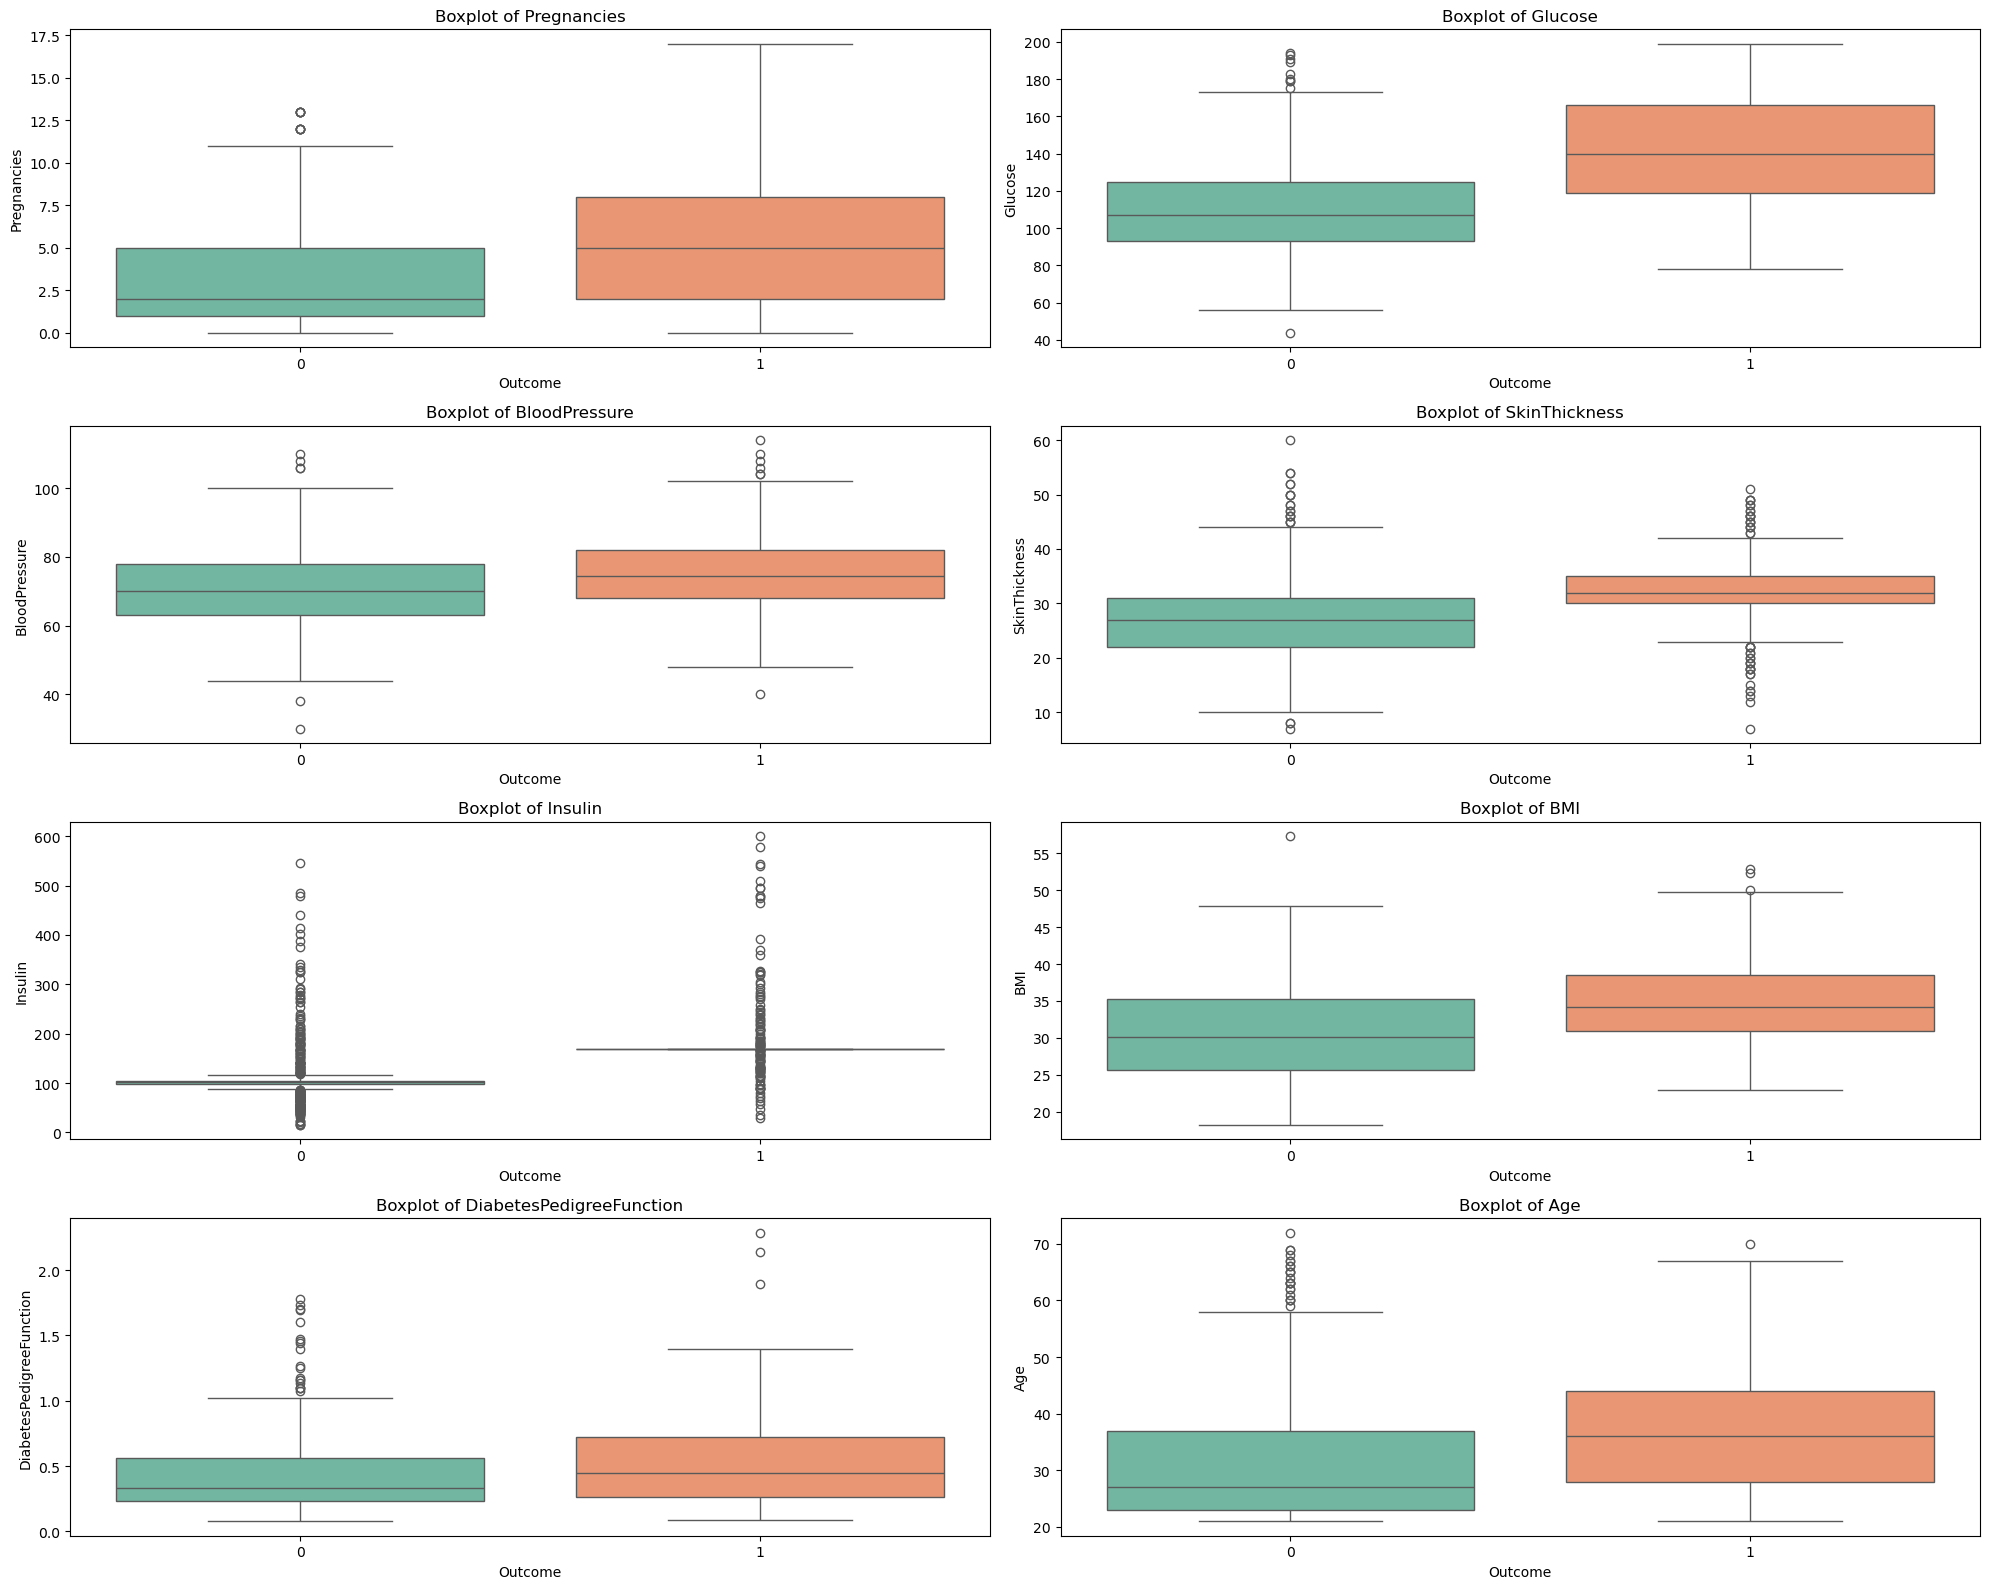

In [14]:

warnings.filterwarnings('ignore')
# Create a figure with 4x4 subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 16))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# List of feature names
features = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'
]

# Generate boxplots for each feature
for i, feature in enumerate(features):
    sns.boxplot(x='Outcome', y=feature, data=data_IQR, ax=axes[i], palette='Set2')
    axes[i].set_title(f'Boxplot of {feature}')
    axes[i].set_xlabel('Outcome')
    axes[i].set_ylabel(feature)

# Adjust layout
plt.tight_layout()
plt.show()

### Removing Outliers based on Z-score::

In [37]:
# Computes z-scores
z_data = np.abs(stats.zscore(data.iloc[:,:-1]))
display(z_data)

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0       0.639947  0.864625       0.032180       0.665181  0.311604  0.169483   
1       0.844885  1.204727       0.528124       0.010112  0.440843  0.848549   
2       1.233880  2.014265       0.693438       0.327535  0.311604  1.328478   
3       0.844885  1.073339       0.528124       0.685405  0.536303  0.630399   
4       1.141852  0.503310       2.677212       0.665181  0.294758  1.551096   
..           ...       ...            ...            ...       ...       ...   
763     1.827813  0.679177       0.298449       2.128317  0.429525  0.067679   
764     0.547919  0.010607       0.197495       0.235210  0.440843  0.634868   
765     0.342981  0.022240       0.032180       0.685405  0.334153  0.906722   
766     0.844885  0.141994       1.024067       0.327535  0.311604  0.339533   
767     0.844885  0.941952       0.197495       0.214986  0.440843  0.295903   

     DiabetesPedigreeFunction       Age  
0                    0.468492  1.425995  
1                    0.365061  0.190672  
2                    0.604397  0.105584  
3                    0.920763  1.041549  
4                    5.484909  0.020496  
..                        ...       ...  
763                  0.908682  2.532136  
764                  0.398282  0.531023  
765                  0.685193  0.275760  
766                  0.371101  1.170732  
767                  0.473785  0.871374  

[768 rows x 8 columns]

In [38]:
# Threshold
threshold = 3
data_Z = data[~((np.abs(z_data))>threshold).any(axis=1)].reset_index(drop=True)
display(data_Z)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6    148.0           72.0           35.0    169.5  33.6   
1              1     85.0           66.0           29.0    102.5  26.6   
2              8    183.0           64.0           32.0    169.5  23.3   
3              1     89.0           66.0           23.0     94.0  28.1   
4              5    116.0           74.0           27.0    102.5  25.6   
..           ...      ...            ...            ...      ...   ...   
714           10    101.0           76.0           48.0    180.0  32.9   
715            2    122.0           70.0           27.0    102.5  36.8   
716            5    121.0           72.0           23.0    112.0  26.2   
717            1    126.0           60.0           32.0    169.5  30.1   
718            1     93.0           70.0           31.0    102.5  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       0.201   30        0  
..                        ...  ...      ...  
714                     0.171   63        0  
715                     0.340   27        0  
716                     0.245   30        0  
717                     0.349   47        1  
718                     0.315   23        0  

[719 rows x 9 columns]

# Class distribution after removing outliers

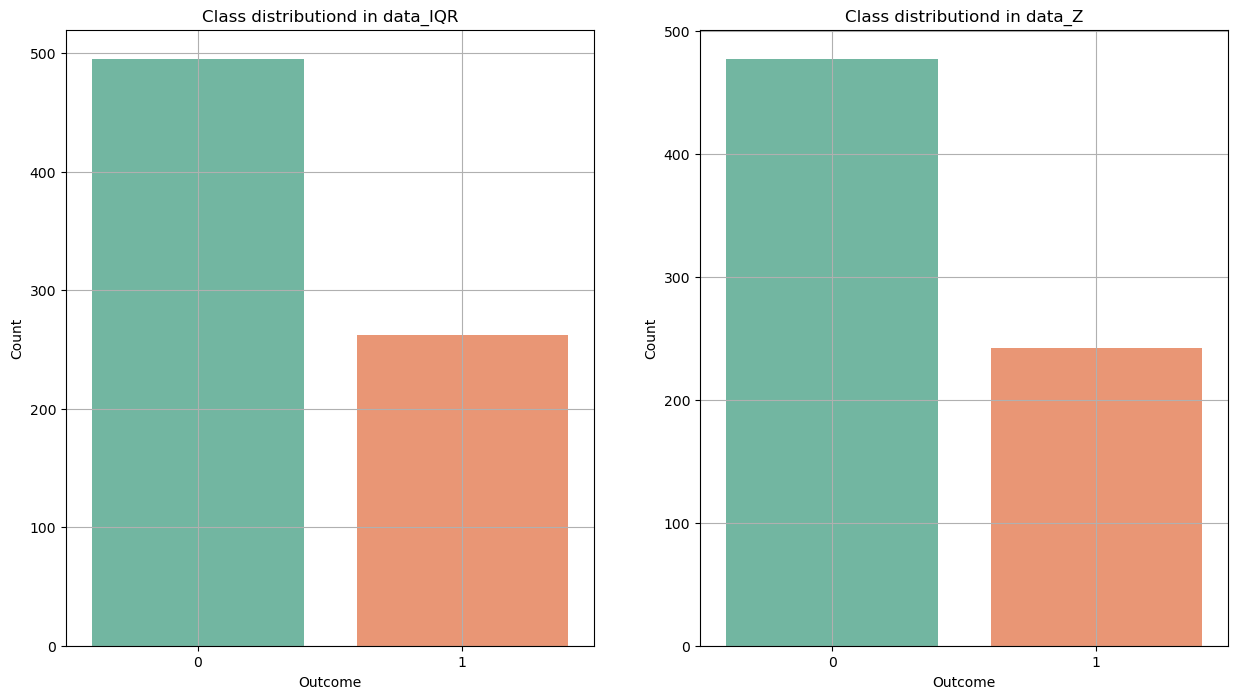

In [35]:
warnings.filterwarnings('ignore')
fig,axes = plt.subplots(1,2,figsize=(15,8))
ax = axes.flatten()
df = [data_IQR,data_Z]
df_name = ['data_IQR','data_Z']
for i in range(2):
    sns.barplot(df[i]['Outcome'].value_counts(),ax=ax[i],palette='Set2')
    ax[i].set_title(f'Class distributiond in {df_name[i]}')
    ax[i].set_xlabel('Outcome')
    ax[i].set_ylabel('Count')
    ax[i].grid(True)
plt.show()

Class distribution on both the clened dataset is imbalanced but data_Z contains less number of entries compare to data_IQR in both the classes.

The above plots ensure that the spreadness of data points of each features has reduced compare to original boxplots, however, this plots has alo didect some points as outliers of each features on new dataset but we assume these are on tolearble situations compare to original case.

# Cor-relation matrix:

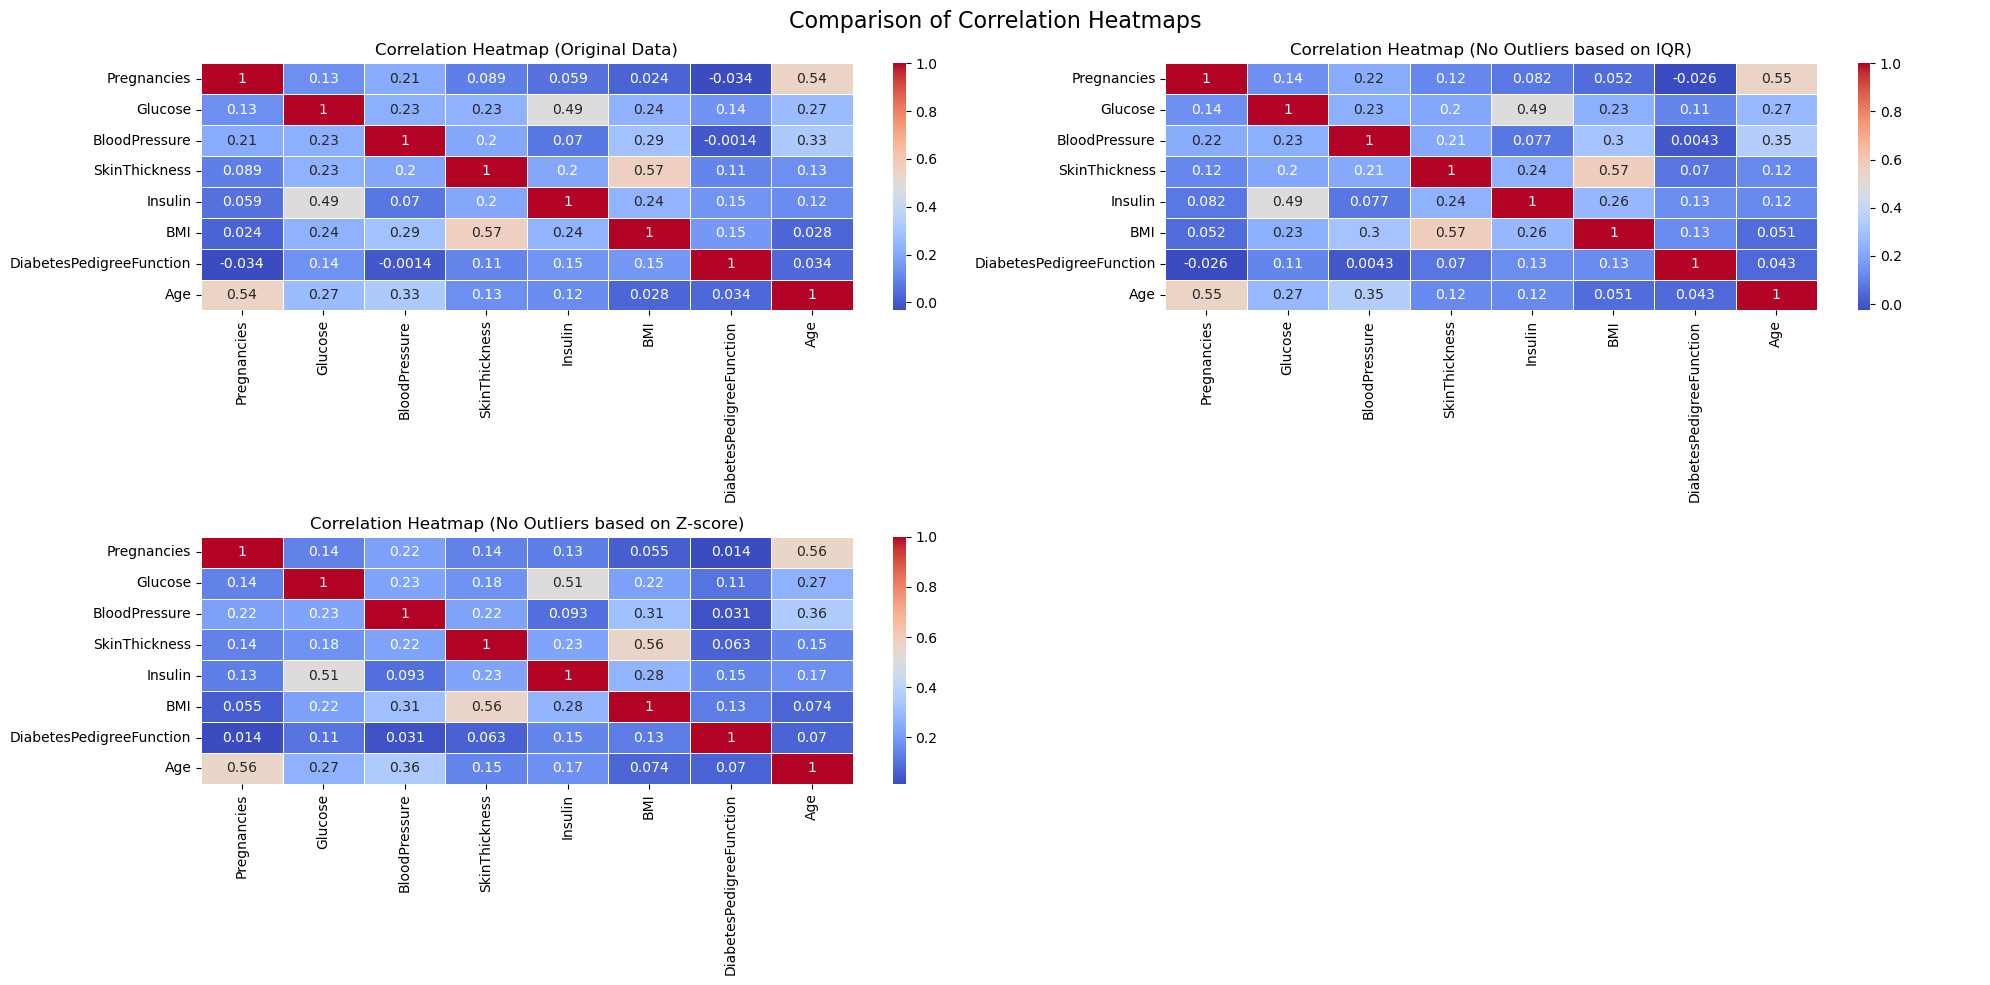

In [44]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()
sns.heatmap(data.iloc[:, :-1].corr(), annot=True, cmap='coolwarm', linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Heatmap (Original Data)')
sns.heatmap(data_IQR.iloc[:,:-1].corr(), annot=True, cmap='coolwarm', linewidths=0.5, ax=axes[1])
axes[1].set_title('Correlation Heatmap (No Outliers based on IQR)')
sns.heatmap(data_Z.iloc[:,:-1].corr(), annot=True, cmap='coolwarm', linewidths=0.5, ax=axes[2])
axes[2].set_title('Correlation Heatmap (No Outliers based on Z-score)')
axes[3].axis('off')
# Add a global title for the entire figure
fig.suptitle('Comparison of Correlation Heatmaps', fontsize=16)

# Show the plot
plt.tight_layout()  # Adjust the layout to fit the suptitle
plt.show()

1The above  plots tell us that removing outliers based on z-score and IQR does not effect much on co-relation matrix , however there not much co-linearity presence in our original and without outliers datset.



In [39]:
data_IQR.to_csv('IQR_Cleaned_data.csv')
data_Z.to_csv('Z_score_cleaned_data.csv')

In [48]:
data_IQR = pd.read_csv('IQR_Cleaned_data.csv')
data_IQR.drop(columns=['Unnamed: 0'],inplace=True)
data_Z = pd.read_csv('Z_score_cleaned_data.csv')
data_Z.drop(columns=['Unnamed: 0'],inplace=True)

# Features Engeneering:

Since our dataset has various types of distribution in different features, so we will introduce new features based on medical terms to capture the complex pattern of the dataset.

Weight vs BMI:

BMI categories are typically defined as:

Underweight: BMI < 18.5
Normal weight: 18.5 ≤ BMI < 24.9
Overweight: 25 ≤ BMI < 29.9
Obesity: BMI ≥ 30

For the 2-hour serum insulin, a common class is:

Normal: 16-166 mIU/L else Abnormal

for 2-hour plasma glucose levels into Low, Normal, and High ranges:

Low:  < 70 mg/dL.

Normal: ≤ 140 mg/dL

High: > 140 mg/dL


In [49]:
# Feature engineering
# Introducing weight columns based on BMI
NewBMI = ['Underweight','Normal','Over','Obesity']
data_IQR['Weight'] = pd.cut(data_IQR['BMI'],bins=[-float('inf'), 18.5, 24.9, 29.9, float('inf')],labels=NewBMI)
data_Z['Weight'] = pd.cut(data_Z['BMI'],bins=[-float('inf'), 18.5, 24.9, 29.9, float('inf')],labels=NewBMI)

# Introducing Insulin status
data_Z['InsulinStatus'] = data_Z['Insulin'].apply(lambda x: 'Normal' if (x >= 16  and x <=166) else 'Abnormal')
data_IQR['InsulinStatus'] = data_IQR['Insulin'].apply(lambda x: 'Normal' if (x >= 16  and x <=166) else 'Abnormal')

# Glucose level
levels = ['Low','Normal','High']
data_IQR['GlucoseLevel'] = pd.cut(data_IQR['Glucose'],bins=[-float('inf'), 70, 140, float('inf')],labels=levels)
data_Z['GlucoseLevel'] = pd.cut(data_Z['Glucose'],bins=[-float('inf'), 70, 140, float('inf')],labels=levels)

# Display 
display(data_IQR.head())
display(data_Z.head())



Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0    169.5  33.6   
1            1     85.0           66.0           29.0    102.5  26.6   
2            8    183.0           64.0           32.0    169.5  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome   Weight InsulinStatus GlucoseLevel  
0                     0.627   50        1  Obesity      Abnormal         High  
1                     0.351   31        0     Over        Normal       Normal  
2                     0.672   32        1   Normal      Abnormal         High  
3                     0.167   21        0     Over        Normal       Normal  
4                     2.288   33        1  Obesity      Abnormal       Normal

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0    169.5  33.6   
1            1     85.0           66.0           29.0    102.5  26.6   
2            8    183.0           64.0           32.0    169.5  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            5    116.0           74.0           27.0    102.5  25.6   

   DiabetesPedigreeFunction  Age  Outcome   Weight InsulinStatus GlucoseLevel  
0                     0.627   50        1  Obesity      Abnormal         High  
1                     0.351   31        0     Over        Normal       Normal  
2                     0.672   32        1   Normal      Abnormal         High  
3                     0.167   21        0     Over        Normal       Normal  
4                     0.201   30        0     Over        Normal       Normal

### label encoding:

In [46]:
# Numerical features
Catg_featurers = ['Weight','InsulinStatus', 'GlucoseLevel']
Num_features = data.columns.drop(['Outcome']).values
print('\nCategorical features are: ',Catg_featurers)
print('\nNumerical features are: ',Num_features)
print('\nTarget variable is : Outcome')



Categorical features are:  ['Weight', 'InsulinStatus', 'GlucoseLevel']

Numerical features are:  ['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age']

Target variable is : Outcome


In [50]:
# Initialize Ordinal Encoder
encoder1 = OrdinalEncoder(categories=[['Underweight', 'Normal', 'Over', 'Obesity']])
encoder2 = OrdinalEncoder(categories=[['Normal','Abnormal']])
encoder3 = OrdinalEncoder(categories=[['Low','Normal','High']])
data_IQR['Weight'] = encoder1.fit_transform(data_IQR[['Weight']])
data_Z['Weight'] = encoder1.fit_transform(data_Z[['Weight']])
data_IQR['InsulinStatus'] = encoder2.fit_transform(data_IQR[['InsulinStatus']])
data_Z['InsulinStatus'] = encoder2.fit_transform(data_Z[['InsulinStatus']])
data_IQR['GlucoseLevel'] = encoder3.fit_transform(data_IQR[['GlucoseLevel']])
data_Z['GlucoseLevel'] = encoder3.fit_transform(data_Z[['GlucoseLevel']])
display(data_IQR)
display(data_Z)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6    148.0           72.0           35.0    169.5  33.6   
1              1     85.0           66.0           29.0    102.5  26.6   
2              8    183.0           64.0           32.0    169.5  23.3   
3              1     89.0           66.0           23.0     94.0  28.1   
4              0    137.0           40.0           35.0    168.0  43.1   
..           ...      ...            ...            ...      ...   ...   
752           10    101.0           76.0           48.0    180.0  32.9   
753            2    122.0           70.0           27.0    102.5  36.8   
754            5    121.0           72.0           23.0    112.0  26.2   
755            1    126.0           60.0           32.0    169.5  30.1   
756            1     93.0           70.0           31.0    102.5  30.4   

     DiabetesPedigreeFunction  Age  Outcome  Weight  InsulinStatus  \
0                       0.627   50        1     3.0            1.0   
1                       0.351   31        0     2.0            0.0   
2                       0.672   32        1     1.0            1.0   
3                       0.167   21        0     2.0            0.0   
4                       2.288   33        1     3.0            1.0   
..                        ...  ...      ...     ...            ...   
752                     0.171   63        0     3.0            1.0   
753                     0.340   27        0     3.0            0.0   
754                     0.245   30        0     2.0            0.0   
755                     0.349   47        1     3.0            1.0   
756                     0.315   23        0     3.0            0.0   

     GlucoseLevel  
0             2.0  
1             1.0  
2             2.0  
3             1.0  
4             1.0  
..            ...  
752           1.0  
753           1.0  
754           1.0  
755           1.0  
756           1.0  

[757 rows x 12 columns]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6    148.0           72.0           35.0    169.5  33.6   
1              1     85.0           66.0           29.0    102.5  26.6   
2              8    183.0           64.0           32.0    169.5  23.3   
3              1     89.0           66.0           23.0     94.0  28.1   
4              5    116.0           74.0           27.0    102.5  25.6   
..           ...      ...            ...            ...      ...   ...   
714           10    101.0           76.0           48.0    180.0  32.9   
715            2    122.0           70.0           27.0    102.5  36.8   
716            5    121.0           72.0           23.0    112.0  26.2   
717            1    126.0           60.0           32.0    169.5  30.1   
718            1     93.0           70.0           31.0    102.5  30.4   

     DiabetesPedigreeFunction  Age  Outcome  Weight  InsulinStatus  \
0                       0.627   50        1     3.0            1.0   
1                       0.351   31        0     2.0            0.0   
2                       0.672   32        1     1.0            1.0   
3                       0.167   21        0     2.0            0.0   
4                       0.201   30        0     2.0            0.0   
..                        ...  ...      ...     ...            ...   
714                     0.171   63        0     3.0            1.0   
715                     0.340   27        0     3.0            0.0   
716                     0.245   30        0     2.0            0.0   
717                     0.349   47        1     3.0            1.0   
718                     0.315   23        0     3.0            0.0   

     GlucoseLevel  
0             2.0  
1             1.0  
2             2.0  
3             1.0  
4             1.0  
..            ...  
714           1.0  
715           1.0  
716           1.0  
717           1.0  
718           1.0  

[719 rows x 12 columns]

In [95]:
data_IQR.to_csv('Labeld_cleaned_IQR.csv')
data_Z.to_csv('Labeld_cleaned_Z.csv')

In [2]:
data_IQR = pd.read_csv('Labeld_cleaned_IQR.csv')
data_IQR.drop(columns=['Unnamed: 0'],inplace=True)
data_IQR

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6    148.0           72.0           35.0    169.5  33.6   
1              1     85.0           66.0           29.0    102.5  26.6   
2              8    183.0           64.0           32.0    169.5  23.3   
3              1     89.0           66.0           23.0     94.0  28.1   
4              0    137.0           40.0           35.0    168.0  43.1   
..           ...      ...            ...            ...      ...   ...   
752           10    101.0           76.0           48.0    180.0  32.9   
753            2    122.0           70.0           27.0    102.5  36.8   
754            5    121.0           72.0           23.0    112.0  26.2   
755            1    126.0           60.0           32.0    169.5  30.1   
756            1     93.0           70.0           31.0    102.5  30.4   

     DiabetesPedigreeFunction  Age  Outcome  Weight  InsulinStatus  \
0                       0.627   50        1     3.0            1.0   
1                       0.351   31        0     2.0            0.0   
2                       0.672   32        1     1.0            1.0   
3                       0.167   21        0     2.0            0.0   
4                       2.288   33        1     3.0            1.0   
..                        ...  ...      ...     ...            ...   
752                     0.171   63        0     3.0            1.0   
753                     0.340   27        0     3.0            0.0   
754                     0.245   30        0     2.0            0.0   
755                     0.349   47        1     3.0            1.0   
756                     0.315   23        0     3.0            0.0   

     GlucoseLevel  
0             2.0  
1             1.0  
2             2.0  
3             1.0  
4             1.0  
..            ...  
752           1.0  
753           1.0  
754           1.0  
755           1.0  
756           1.0  

[757 rows x 12 columns]

# Model Training and Testing:

### On cleaned data based on IQR:

For further analysis, I am going to use data set that is cleaned based on IQR rules.

In [51]:
# Features set
X = data_IQR.drop(columns=['Outcome'])
# Target/Response
y = data_IQR['Outcome'].values

### Features Scalling:

In [52]:
# Numric columns
col = (X.columns)[:8]
# Categorical features
catg_x = X.iloc[:,8:11]
# numeric features
numeric_x = X.iloc[:,:8]
# Standaarize
scaler = StandardScaler()
numeric_x = scaler.fit_transform(numeric_x)
numeric_x = pd.DataFrame(numeric_x,columns=col)
X = pd.concat([numeric_x,catg_x],axis=1)
X = X.values

In [5]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Tunning Hyper-parametrs for KNN:

In [103]:
# Step 2: Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_neighbors = trial.suggest_int('n_neighbors', 3, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 2)  # Minkowski metric parameter (p=1: Manhattan, p=2: Euclidean)
    
    # Initialize the classifier with trial parameters
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
    
    # Pipeline with SMOTE applied in each fold
    pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  # SMOTE to balance classes
        ('classifier', knn)  # K-Neighbors Classifier 
    ])
    
    # Step 3: 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Step 4: Compute cross-validated score
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1)
    
    # Step 5: Return the mean accuracy as the objective to maximize
    return np.mean(scores)

# Step 6: Create the Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Step 7: Print the best hyperparameters and best score
print('Best hyperparameters: ', study.best_params)
print('Best cross-validated accuracy: {:.4f}'.format(study.best_value))


[I 2024-08-30 17:38:25,323] A new study created in memory with name: no-name-5d2b2f84-0205-41e4-ba6e-c1ac7a08d99e
[I 2024-08-30 17:38:27,092] Trial 0 finished with value: 0.8396694214876034 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.8396694214876034.
[I 2024-08-30 17:38:28,602] Trial 1 finished with value: 0.8297520661157025 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.8396694214876034.
[I 2024-08-30 17:38:30,163] Trial 2 finished with value: 0.8280991735537191 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.8396694214876034.
[I 2024-08-30 17:38:31,622] Trial 3 finished with value: 0.8396694214876034 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.8396694214876034.
[I 2024-08-30 17:38:33,142] Trial 4 finished with value: 0.8347107438016529 and parameters: {'n_neighbors': 18, 'weights':

Best hyperparameters:  {'n_neighbors': 19, 'weights': 'distance', 'p': 1}
Best cross-validated accuracy: 0.8661


### Evaluation:

In [106]:
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors=19, weights= 'distance', p= 1)
# # Apply SMOTE to the training data
smote = SMOTE(random_state=101)
X_train, y_train = smote.fit_resample(X_train, y_train)
# # Train the classifier
knn.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = knn.predict(X_test)
y_train_pred = knn.predict(X_train)
# Evaluate the classifier
tr_acc = accuracy_score(y_train,y_train_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {tr_acc:.2f}')
print(f"Test Accuracy: {accuracy:.2f}")
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Train Accuracy: 1.00
Test Accuracy: 0.84
[[83 15]
 [ 9 45]]
              precision    recall  f1-score   support

           0       0.90      0.85      0.87        98
           1       0.75      0.83      0.79        54

    accuracy                           0.84       152
   macro avg       0.83      0.84      0.83       152
weighted avg       0.85      0.84      0.84       152



### Hyperparameter tunning on Logistic regression:

In [10]:
def objective(trial):
    # Define the search space for hyperparameters
    C = trial.suggest_float('C', 1e-5, 1e5, log=True)  # Regularization strength, updated to use suggest_float with log=True
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    
    # If penalty is 'elasticnet', then we need to specify the l1_ratio
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0, 1)  # Updated to use suggest_float
    else:
        l1_ratio = None  # Not used for 'l1' or 'l2'
    
    # Initialize the classifier with trial parameters
    clf = LogisticRegression(C=C, penalty=penalty, l1_ratio=l1_ratio, solver='saga', max_iter=1000)
    
    # Pipeline with SMOTE applied in each fold
    pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  # SMOTE to balance classes
        ('classifier', clf)  # Logistic Regression
    ])
    
    # 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Compute cross-validated score
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1)
    
    # Return the mean accuracy as the objective to maximize
    return np.mean(scores)

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and best score
print('Best hyperparameters: ', study.best_params)
print('Best cross-validated accuracy: {:.4f}'.format(study.best_value))

[I 2024-08-30 17:58:35,738] A new study created in memory with name: no-name-7883b44f-622f-4be0-a94f-51afd3d7f809
[I 2024-08-30 17:58:42,034] Trial 0 finished with value: 0.7652892561983471 and parameters: {'C': 0.0038276833201988368, 'penalty': 'elasticnet', 'l1_ratio': 0.3435659804093487}. Best is trial 0 with value: 0.7652892561983471.
[I 2024-08-30 17:58:43,462] Trial 1 finished with value: 0.8545454545454547 and parameters: {'C': 654.8106403984918, 'penalty': 'l1'}. Best is trial 1 with value: 0.8545454545454547.
[I 2024-08-30 17:58:44,846] Trial 2 finished with value: 0.8578512396694216 and parameters: {'C': 0.7206550729013643, 'penalty': 'l2'}. Best is trial 2 with value: 0.8578512396694216.
[I 2024-08-30 17:58:46,230] Trial 3 finished with value: 0.8528925619834711 and parameters: {'C': 0.16668121899904598, 'penalty': 'elasticnet', 'l1_ratio': 0.09050986246468962}. Best is trial 2 with value: 0.8578512396694216.
[I 2024-08-30 17:58:47,764] Trial 4 finished with value: 0.8545454

Best hyperparameters:  {'C': 0.7206550729013643, 'penalty': 'l2'}
Best cross-validated accuracy: 0.8579


In [11]:
# Initialize the model
# model = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.05)
model = LogisticRegression(C=0.7206550729013643, penalty='l2')
# # Apply SMOTE to the training data
smote = SMOTE(random_state=101)
X_train, y_train = smote.fit_resample(X_train, y_train)
# # Train the classifier
model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
# Evaluate the classifier
tr_acc = accuracy_score(y_train,y_train_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {tr_acc:.2f}')
print(f"Test Accuracy: {accuracy:.2f}")
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


Train Accuracy: 0.86
Test Accuracy: 0.82
[[80 18]
 [ 9 45]]
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        98
           1       0.71      0.83      0.77        54

    accuracy                           0.82       152
   macro avg       0.81      0.82      0.81       152
weighted avg       0.83      0.82      0.82       152



### Hyperparameter tunning on SVC:

In [10]:
def objective(trial):
    # Define the search space for hyperparameters
    C = trial.suggest_float('C', 1e-5, 1e5, log=True)  # Regularization parameter with log scale
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])  # Kernel type
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])  # Kernel coefficient for 'rbf', 'poly'
    degree = trial.suggest_int('degree', 2, 5)  # Degree of the polynomial kernel function (only if kernel='poly')
    
    # Initialize the classifier with trial parameters
    svc = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, random_state=42)
    
    # Pipeline with SMOTE applied in each fold
    pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  # SMOTE to balance classes
        ('classifier', svc)  # Support Vector Classifier
    ])
    
    # 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Compute cross-validated score
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1)
    
    # Return the mean accuracy as the objective to maximize
    return np.mean(scores)

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and best score
print('Best hyperparameters: ', study.best_params)
print('Best cross-validated accuracy: {:.4f}'.format(study.best_value))


[I 2024-08-30 18:18:49,441] A new study created in memory with name: no-name-e3183a67-56e6-4485-af4c-dbc37a851ce9
[I 2024-08-30 18:18:55,144] Trial 0 finished with value: 0.8099173553719009 and parameters: {'C': 36035.57267216935, 'kernel': 'poly', 'gamma': 'scale', 'degree': 4}. Best is trial 0 with value: 0.8099173553719009.
[I 2024-08-30 18:18:56,712] Trial 1 finished with value: 0.775206611570248 and parameters: {'C': 207.88624472557777, 'kernel': 'poly', 'gamma': 'auto', 'degree': 3}. Best is trial 0 with value: 0.8099173553719009.
[I 2024-08-30 18:18:58,146] Trial 2 finished with value: 0.7917355371900826 and parameters: {'C': 4.5093853064017066e-05, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 5}. Best is trial 0 with value: 0.8099173553719009.
[I 2024-08-30 18:18:59,660] Trial 3 finished with value: 0.803305785123967 and parameters: {'C': 4.50810477158239e-05, 'kernel': 'linear', 'gamma': 'auto', 'degree': 4}. Best is trial 0 with value: 0.8099173553719009.
[I 2024-08-30 18:19:0

Best hyperparameters:  {'C': 0.2899347674794531, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 2}
Best cross-validated accuracy: 0.8678


In [11]:
# Initialize the model
model = SVC(C=0.2899347674794531, kernel='rbf', gamma='scale', degree=2, random_state=42)
# # Apply SMOTE to the training data
smote = SMOTE(random_state=101)
X_train, y_train = smote.fit_resample(X_train, y_train)
# # Train the classifier
model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
# Evaluate the classifier
tr_acc = accuracy_score(y_train,y_train_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {tr_acc:.2f}')
print(f"Test Accuracy: {accuracy:.2f}")
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


Train Accuracy: 0.87
Test Accuracy: 0.84
[[84 14]
 [10 44]]
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        98
           1       0.76      0.81      0.79        54

    accuracy                           0.84       152
   macro avg       0.83      0.84      0.83       152
weighted avg       0.85      0.84      0.84       152



### Hyperparameter tunning on RandomForest:

In [14]:
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 200)  # Number of trees in the forest
    max_depth = trial.suggest_int('max_depth', 5, 50)  # Maximum depth of the tree
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  # Minimum number of samples required to split an internal node
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)  # Minimum number of samples required to be at a leaf node
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])  # Number of features to consider at each split
    
    # Initialize the Random Forest Classifier with trial parameters
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Pipeline with SMOTE applied in each fold
    pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  # SMOTE to balance classes
        ('classifier', rf)  # Random Forest Classifier
    ])
    
    # 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Compute cross-validated score
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1)
    
    # Return the mean accuracy as the objective to maximize
    return np.mean(scores)
# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and best score
print('Best hyperparameters: ', study.best_params)
print('Best cross-validated accuracy: {:.4f}'.format(study.best_value))

[I 2024-08-30 18:37:18,639] A new study created in memory with name: no-name-37465640-8c6e-4fb6-a44d-a47afdcaa0e3
[I 2024-08-30 18:37:20,913] Trial 0 finished with value: 0.8879070137727888 and parameters: {'n_estimators': 135, 'max_depth': 32, 'min_samples_split': 9, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 0 with value: 0.8879070137727888.
[I 2024-08-30 18:37:22,852] Trial 1 finished with value: 0.8866411909879787 and parameters: {'n_estimators': 99, 'max_depth': 43, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8879070137727888.
[I 2024-08-30 18:37:24,649] Trial 2 finished with value: 0.8891569142584188 and parameters: {'n_estimators': 101, 'max_depth': 38, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8891569142584188.
[I 2024-08-30 18:37:26,628] Trial 3 finished with value: 0.8878990526231989 and parameters: {'n_estimators': 184, 'max_depth': 31, '

Best hyperparameters:  {'n_estimators': 180, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}
Best cross-validated accuracy: 0.9093


In [15]:
# Initialize the model
# Initialize the Random Forest Classifier with trial parameters
model = RandomForestClassifier(
    n_estimators=180,
    max_depth=17,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='log2',
    random_state=42
)
# # Apply SMOTE to the training data
smote = SMOTE(random_state=101)
X_train, y_train = smote.fit_resample(X_train, y_train)
# # Train the classifier
model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
# Evaluate the classifier
tr_acc = accuracy_score(y_train,y_train_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {tr_acc:.2f}')
print(f"Test Accuracy: {accuracy:.2f}")
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


Train Accuracy: 0.99
Test Accuracy: 0.87
[[88 10]
 [10 44]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        98
           1       0.81      0.81      0.81        54

    accuracy                           0.87       152
   macro avg       0.86      0.86      0.86       152
weighted avg       0.87      0.87      0.87       152



### Hyperparametrs tunning on GradientBoosting:

In [17]:
# Objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 500)  # Number of boosting stages to be run
    max_depth = trial.suggest_int('max_depth', 3, 20)  # Maximum depth of individual estimators
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)  # Learning rate shrinks the contribution of each tree
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  # Minimum number of samples required to split an internal node
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)  # Minimum number of samples required to be at a leaf node
    subsample = trial.suggest_float('subsample', 0.5, 1.0)  # Fraction of samples to be used for fitting the individual base learners
    
    # Initialize the Gradient Boosting Classifier with trial parameters
    gbc = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=42
    )
    
    # Pipeline with SMOTE applied in each fold
    pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  # SMOTE to balance classes
        ('classifier', gbc)  # Gradient Boosting Classifier
    ])
    
    # 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Compute cross-validated score
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1)
    
    # Return the mean accuracy as the objective to maximize
    return np.mean(scores)

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and best score
print('Best hyperparameters: ', study.best_params)
print('Best cross-validation accuracy: ', study.best_value)


[I 2024-08-30 18:45:26,552] A new study created in memory with name: no-name-a5df4048-77f2-4745-88d4-3ea960b6df44
[I 2024-08-30 18:45:36,537] Trial 0 finished with value: 0.8916885598280393 and parameters: {'n_estimators': 437, 'max_depth': 14, 'learning_rate': 0.2037298647455049, 'min_samples_split': 7, 'min_samples_leaf': 13, 'subsample': 0.7766962285975474}. Best is trial 0 with value: 0.8916885598280393.
[I 2024-08-30 18:45:40,930] Trial 1 finished with value: 0.9105724066555212 and parameters: {'n_estimators': 390, 'max_depth': 8, 'learning_rate': 0.020536517343214093, 'min_samples_split': 12, 'min_samples_leaf': 14, 'subsample': 0.6535521763184665}. Best is trial 1 with value: 0.9105724066555212.
[I 2024-08-30 18:45:44,282] Trial 2 finished with value: 0.8916726375288592 and parameters: {'n_estimators': 198, 'max_depth': 14, 'learning_rate': 0.5009178151664768, 'min_samples_split': 11, 'min_samples_leaf': 19, 'subsample': 0.8296410935628373}. Best is trial 1 with value: 0.9105724

Best hyperparameters:  {'n_estimators': 475, 'max_depth': 13, 'learning_rate': 0.03563376745110623, 'min_samples_split': 13, 'min_samples_leaf': 7, 'subsample': 0.8882846596709258}
Best cross-validation accuracy:  0.920643260886872


In [18]:
# Initialize the model
# Initialize the Gradient Boosting Classifier with trial parameters
model = GradientBoostingClassifier(
    n_estimators=475,
    max_depth=13,
    learning_rate= 0.03563376745110623,
    min_samples_split=13,
    min_samples_leaf=7,
    subsample=0.8882846596709258,
    random_state=42
)
# # Apply SMOTE to the training data
smote = SMOTE(random_state=101)
X_train, y_train = smote.fit_resample(X_train, y_train)
# # Train the classifier
model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
# Evaluate the classifier
tr_acc = accuracy_score(y_train,y_train_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {tr_acc:.2f}')
print(f"Test Accuracy: {accuracy:.2f}")
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


Train Accuracy: 1.00
Test Accuracy: 0.88
[[88 10]
 [ 9 45]]
              precision    recall  f1-score   support

           0       0.91      0.90      0.90        98
           1       0.82      0.83      0.83        54

    accuracy                           0.88       152
   macro avg       0.86      0.87      0.86       152
weighted avg       0.88      0.88      0.88       152



### Hyperparameters tunning on XGBoosting:

In [20]:
# Objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 500)  # Number of boosting rounds
    max_depth = trial.suggest_int('max_depth', 3, 20)  # Maximum depth of the tree
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)  # Step size shrinkage used to prevent overfitting
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)  # Minimum sum of instance weight (hessian) needed in a child
    subsample = trial.suggest_float('subsample', 0.5, 1.0)  # Subsample ratio of the training instance
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)  # Subsample ratio of columns when constructing each tree
    gamma = trial.suggest_float('gamma', 0, 5)  # Minimum loss reduction required to make a further partition on a leaf node
    
    # Initialize the XGBoost Classifier with trial parameters
    xgb = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        random_state=42,
        eval_metric='mlogloss'
    )
    
    # Pipeline with SMOTE applied in each fold
    pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  # SMOTE to balance classes
        ('classifier', xgb)  # XGBoost Classifier
    ])
    
    # 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Compute cross-validated score
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1)
    
    # Return the mean accuracy as the objective to maximize
    return np.mean(scores)

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and best score
print('Best hyperparameters: ', study.best_params)
print('Best cross-validation accuracy: ', study.best_value)


[I 2024-08-30 18:57:28,671] A new study created in memory with name: no-name-0be3496d-30da-4560-a002-be8f65211868
[I 2024-08-30 18:57:36,935] Trial 0 finished with value: 0.8954621447336996 and parameters: {'n_estimators': 54, 'max_depth': 10, 'learning_rate': 0.046102345483147865, 'min_child_weight': 7, 'subsample': 0.8699145413472855, 'colsample_bytree': 0.7322449412737924, 'gamma': 0.9181416227041089}. Best is trial 0 with value: 0.8954621447336996.
[I 2024-08-30 18:57:40,003] Trial 1 finished with value: 0.8980017514529098 and parameters: {'n_estimators': 456, 'max_depth': 17, 'learning_rate': 0.10662094842426798, 'min_child_weight': 10, 'subsample': 0.598017825591008, 'colsample_bytree': 0.8819241490470489, 'gamma': 1.3773815064176298}. Best is trial 1 with value: 0.8980017514529098.
[I 2024-08-30 18:57:43,189] Trial 2 finished with value: 0.9042830984794206 and parameters: {'n_estimators': 421, 'max_depth': 11, 'learning_rate': 0.03712497800290178, 'min_child_weight': 9, 'subsamp

Best hyperparameters:  {'n_estimators': 460, 'max_depth': 12, 'learning_rate': 0.3011332222725638, 'min_child_weight': 1, 'subsample': 0.6403771143602026, 'colsample_bytree': 0.9765325364873428, 'gamma': 0.002961917103311479}
Best cross-validation accuracy:  0.9244327680917124


In [21]:
# Initialize the model
# Initialize the EXtreme Gradient Boosting Classifier with trial parameters
model = XGBClassifier(
    n_estimators=460,
    max_depth=12,
    learning_rate=0.3011332222725638,
    min_child_weight=1,
    subsample=0.6403771143602026,
    colsample_bytree= 0.9765325364873428,
    gamma=0.002961917103311479,
    random_state=42,
    eval_metric='mlogloss'
)
# # Apply SMOTE to the training data
smote = SMOTE(random_state=101)
X_train, y_train = smote.fit_resample(X_train, y_train)
# # Train the classifier
model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
# Evaluate the classifier
tr_acc = accuracy_score(y_train,y_train_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {tr_acc:.2f}')
print(f"Test Accuracy: {accuracy:.2f}")
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


Train Accuracy: 1.00
Test Accuracy: 0.87
[[86 12]
 [ 8 46]]
              precision    recall  f1-score   support

           0       0.91      0.88      0.90        98
           1       0.79      0.85      0.82        54

    accuracy                           0.87       152
   macro avg       0.85      0.86      0.86       152
weighted avg       0.87      0.87      0.87       152



### Hyperparametrs tunning on GaussNaiveBayes:

In [23]:
# Define objective function for Optuna
def objective(trial):
    # Suggest a value for var_smoothing parameter
    var_smoothing = trial.suggest_float('var_smoothing', 1e-11, 1e-7,log=True)
    
    # Initialize GaussianNB with the suggested parameter
    model = GaussianNB(var_smoothing=var_smoothing)
    
    # Perform cross-validation and calculate the mean accuracy
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    
    return accuracy

# Create study object
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best cross-validation accuracy: ", study.best_value)

# Train the model with the best parameters
best_var_smoothing = study.best_params['var_smoothing']
model = GaussianNB(var_smoothing=best_var_smoothing)
model.fit(X_train, y_train)

# Evaluate on the test set
test_accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


[I 2024-08-30 19:12:19,545] A new study created in memory with name: no-name-252c537e-b177-48a7-9573-ab617f181c79
[I 2024-08-30 19:12:19,569] Trial 0 finished with value: 0.8413422498208742 and parameters: {'var_smoothing': 9.644391200073805e-11}. Best is trial 0 with value: 0.8413422498208742.
[I 2024-08-30 19:12:19,592] Trial 1 finished with value: 0.8413422498208742 and parameters: {'var_smoothing': 1.3033963450117086e-08}. Best is trial 0 with value: 0.8413422498208742.
[I 2024-08-30 19:12:19,614] Trial 2 finished with value: 0.8413422498208742 and parameters: {'var_smoothing': 5.512864044293641e-09}. Best is trial 0 with value: 0.8413422498208742.
[I 2024-08-30 19:12:19,636] Trial 3 finished with value: 0.8413422498208742 and parameters: {'var_smoothing': 1.4147717105873342e-11}. Best is trial 0 with value: 0.8413422498208742.
[I 2024-08-30 19:12:19,658] Trial 4 finished with value: 0.8413422498208742 and parameters: {'var_smoothing': 3.565451684693091e-08}. Best is trial 0 with v

Best hyperparameters:  {'var_smoothing': 9.644391200073805e-11}
Best cross-validation accuracy:  0.8413422498208742
Test Accuracy: 0.83


In [24]:
# Initialize the model
# Initialize the EXtreme Gradient Boosting Classifier with trial parameters
model = GaussianNB(var_smoothing=9.644391200073805e-11)
# # Apply SMOTE to the training data
smote = SMOTE(random_state=101)
X_train, y_train = smote.fit_resample(X_train, y_train)
# # Train the classifier
model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
# Evaluate the classifier
tr_acc = accuracy_score(y_train,y_train_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {tr_acc:.2f}')
print(f"Test Accuracy: {accuracy:.2f}")
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


Train Accuracy: 0.85
Test Accuracy: 0.83
[[81 17]
 [ 9 45]]
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        98
           1       0.73      0.83      0.78        54

    accuracy                           0.83       152
   macro avg       0.81      0.83      0.82       152
weighted avg       0.84      0.83      0.83       152



### Hyperparameters tunning on Neural networks:

In [27]:
def objective(trial):
    # Hyperparameters to tune
    n_layers = trial.suggest_int('n_layers', 1, 3)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    # Define the model
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_shape= (X_train.shape[1],)))

    # Add hidden layers with dropout
    for i in range(n_layers):
        model.add(Dense(units=trial.suggest_int(f'n_units_{i}', 32, 128), activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    # Output layer
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              epochs=50,
              batch_size=32,
              verbose=0,
              callbacks=[TFKerasPruningCallback(trial, 'val_accuracy')])

    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]  # Return accuracy

# Start the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2024-08-30 19:26:49,755] A new study created in memory with name: no-name-090fada4-0e8b-4ea9-a80f-4a217c4e991c
/tmp/ipykernel_2311112/2590342917.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
2024-08-30 19:26:49.873451: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
[I 2024-08-30 19:27:06,704] Trial 0 finished with value: 0.8355262875556946 and parameters: {'n_layers': 2, 'dropout_rate': 0.3802851851693094, 'learning_rate': 0.00166243821

Best trial:
  Value: 0.8815789222717285
  Params: 
    n_layers: 1
    dropout_rate: 0.3813260948708474
    learning_rate: 0.0037288763638255217
    n_units_0: 34


In [29]:
# Define the model creation function
def create_model(n_layers, dropout_rate, learning_rate, n_units, input_shape):
    model = Sequential()
    model.add(Dense(units=n_units, activation='relu', input_shape=(input_shape,)))
    
    # Add hidden layers
    for _ in range(n_layers - 1):
        model.add(Dense(units=n_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))  # Adjust the output layer as needed
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',  # Adjust loss function if needed
                  metrics=['accuracy'])
    return model

# Replace X and y with your actual data
X, y = np.random.rand(1000, 20), np.random.randint(0, 2, 1000)

# Best parameters from Optuna
best_n_layers = 1
best_dropout_rate = 0.3813260948708474
best_learning_rate = 0.0037288763638255217
best_n_units = 34

# Create and train the model
model = create_model(best_n_layers, best_dropout_rate, best_learning_rate, best_n_units, X_train.shape[1])
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=1)

# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7121 - loss: 0.6018 - val_accuracy: 0.8125 - val_loss: 0.4421
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8269 - loss: 0.4076 - val_accuracy: 0.7875 - val_loss: 0.3990
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7953 - loss: 0.4106 - val_accuracy: 0.8000 - val_loss: 0.3766
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8378 - loss: 0.3635 - val_accuracy: 0.7750 - val_loss: 0.4055
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8477 - loss: 0.3444 - val_accuracy: 0.8625 - val_loss: 0.2629
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8729 - loss: 0.3151 - val_accuracy: 0.8375 - val_loss: 0.3352
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8736 - loss: 0.3026 - val_accuracy: 0.8750 - val_loss: 0.2621
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8820 - loss: 0.2905 - val_accuracy: 0.8875 - val_loss

In [36]:
# Predict class probabilities on the test data
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = (y_pred_prob > 0.5).astype(int)
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion Matrix:
[[85 13]
 [12 42]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87        98
           1       0.76      0.78      0.77        54

    accuracy                           0.84       152
   macro avg       0.82      0.82      0.82       152
weighted avg       0.84      0.84      0.84       152



Using the dataset which is cleaned based on IQR rules and labeled by OrdinalEncoder, we have seen that many classification models learned the data pattern in the dataset very well but some of them overfitted.

Among of these models, we see that Logistic Regression, Support Vector Machine, Gaussian Naive Bayes classifier and Feed Forward Neural Networks did not overfitted but there is an issue of less recall.
Since we have to care about false negative prediction about diabetes patient, so we choose the models having no over or under fitting and atmost one model having less percentage of overfit among the overfit models to take majority voting.

# Final model training:

In [31]:
# Features set:
X = data_IQR.drop(columns=['Outcome'])
# ------ Numric columns------
col = (X.columns)[:8]
# ---- Categorical features-----
catg_x = X.iloc[:,8:11]
# ----- numeric features---------
numeric_x = X.iloc[:,:8]
# ----- Standaarize---------------
numeric_x = StandardScaler().fit_transform(numeric_x)
numeric_x = pd.DataFrame(numeric_x,columns=col)
X = pd.concat([numeric_x,catg_x],axis=1)
X = X.values

# Target set:
y = data_IQR['Outcome'].values

In [39]:
# Logistic regression
lgr =  LogisticRegression(C=0.7206550729013643, penalty='l2')
lgr.fit(X, y)
print('Logistic regression model has fitted.')
# Support vector machine
svc = SVC(C=0.2899347674794531, kernel='rbf', gamma='scale', degree=2, random_state=42)
svc.fit(X,y)
print('Support vector machine model has fitted.')
# Gaussian Naive Bayes
gnb = GaussianNB(var_smoothing=9.644391200073805e-11)
gnb.fit(X,y)
print('Gaussian Naive Bayes model has fitted.')
# Extreme Gradient Boosting Classifiers
xgb = XGBClassifier(
    n_estimators=460,
    max_depth=12,
    learning_rate=0.3011332222725638,
    min_child_weight=1,
    subsample=0.6403771143602026,
    colsample_bytree=0.9765325364873428,
    gamma=0.002961917103311479,
    random_state=42,
    eval_metric='mlogloss'
)
xgb.fit(X,y)
print('Extreme Gradient Boosting model has fitted.')
# Neural Network model
def create_model(n_layers, dropout_rate, learning_rate, n_units, input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))  # Use Input layer to specify input shape
    
    # Add hidden layers
    model.add(Dense(units=n_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    # Add hidden layers
    for _ in range(n_layers):
        model.add(Dense(units=n_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))  # Adjust the output layer as needed
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',  # Adjust loss function if needed
                  metrics=['accuracy'])
    return model
 # ------Hyperparameters---
best_n_layers = 1
best_dropout_rate = 0.3813260948708474
best_learning_rate = 0.0037288763638255217
best_n_units = 34
# ---- Create model--
# Create the model
input_shape = X.shape[1]  # Number of features in your dataset
NN = create_model(best_n_layers, best_dropout_rate, best_learning_rate, best_n_units, input_shape)
NN.fit(X, y, epochs=10, batch_size=32, verbose=0)
print('Neural Network model has fitted.')

Logistic regression model has fitted.
Support vector machine model has fitted.
Gaussian Naive Bayes model has fitted.
Extreme Gradient Boosting model has fitted.
Neural Network model has fitted.


### Model Evaluations:

In [41]:
def evaluate_model(model, X, y, is_nn=False):
    if is_nn:
        # Predict class probabilities on the dataset
        y_pred_prob = model.predict(X)
        # Convert probabilities to class labels
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Flatten to 1D array for comparison
    else:
        y_pred = model.predict(X)
    
    # Evaluate performance
    accuracy = accuracy_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)
    
    # Extract precision and recall from classification report
    report = classification_report(y, y_pred, output_dict=True)
    
    # Check for class labels dynamically
    positive_class = '1' if '1' in report else '0'
    precision = report[positive_class]['precision']
    recall = report[positive_class]['recall']
    
    return accuracy, conf_matrix, precision, recall

# Store results
results = []

# Logistic Regression
accuracy, conf_matrix, precision, recall = evaluate_model(lgr, X, y)
results.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy,
    'Confusion Matrix': conf_matrix,
    'Precision': precision,
    'Recall': recall
})

# Support Vector Classifier
accuracy, conf_matrix, precision, recall = evaluate_model(svc, X, y)
results.append({
    'Model': 'SVC',
    'Accuracy': accuracy,
    'Confusion Matrix': conf_matrix,
    'Precision': precision,
    'Recall': recall
})

# Gaussian Naive Bayes
accuracy, conf_matrix, precision, recall = evaluate_model(gnb, X, y)
results.append({
    'Model': 'GaussianNB',
    'Accuracy': accuracy,
    'Confusion Matrix': conf_matrix,
    'Precision': precision,
    'Recall': recall
})

# XGBoost
accuracy, conf_matrix, precision, recall = evaluate_model(xgb, X, y)
results.append({
    'Model': 'XGBoost',
    'Accuracy': accuracy,
    'Confusion Matrix': conf_matrix,
    'Precision': precision,
    'Recall': recall
})

# Neural Network
accuracy, conf_matrix, precision, recall = evaluate_model(NN, X, y, is_nn=True)
results.append({
    'Model': 'Neural Network',
    'Accuracy': accuracy,
    'Confusion Matrix': conf_matrix,
    'Precision': precision,
    'Recall': recall
})

# Print results
results_df = pd.DataFrame(results)
display(results_df)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Model  Accuracy        Confusion Matrix  Precision    Recall
0  Logistic Regression  0.854690  [[443, 52], [58, 204]]   0.796875  0.778626
1                  SVC  0.870542  [[449, 46], [52, 210]]   0.820312  0.801527
2           GaussianNB  0.846764  [[423, 72], [44, 218]]   0.751724  0.832061
3              XGBoost  1.000000    [[495, 0], [0, 262]]   1.000000  1.000000
4       Neural Network  0.878468  [[452, 43], [49, 213]]   0.832031  0.812977

The above results shows us that the five models has trained well with somehow reasonable recalls and there is an issue of overfitting and we will take the majority votes of the outputs from these models.

In [53]:
import joblib

In [58]:
# Saving the files for future prediction
# Save the encoders
joblib.dump(encoder1, 'encoder1.pkl')
joblib.dump(encoder2, 'encoder2.pkl')
joblib.dump(encoder3, 'encoder3.pkl')

# Save the standarizer scaler
joblib.dump(scaler, 'scaler.pkl')

# Save Logistic Regression model
joblib.dump(lgr, 'logistic_regression_model.pkl')

# Save Support Vector Classifier model
joblib.dump(svc, 'svc_model.pkl')

# Save Gaussian Naive Bayes model
joblib.dump(gnb, 'gnb_model.pkl')

# Save XGBoost model
joblib.dump(xgb, 'xgb_model.pkl')

[[-0.55697625 -0.04309669 -0.2031029  -1.05999211 -0.49603941 -0.57577431
   0.10392695 -0.27492193  2.          0.          1.        ]]


In [56]:
from tensorflow.keras.models import save_model

# Save Neural Network model in Keras format
NN.save('neural_network_model.keras')

In [ ]:
# New input data preperation


In [84]:
def process_user_input(user_input):
    # Load saved encoders and scaler
    encoder1 = joblib.load('encoder1.pkl')
    encoder2 = joblib.load('encoder2.pkl')
    encoder3 = joblib.load('encoder3.pkl')
    scaler = joblib.load('scaler.pkl')
    
    # Create a DataFrame from user input
    df = pd.DataFrame([user_input], columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
    
    # Introducing weight columns based on BMI
    NewBMI = ['Underweight', 'Normal', 'Over', 'Obesity']
    df['Weight'] = pd.cut(df['BMI'], bins=[-float('inf'), 18.5, 24.9, 29.9, float('inf')], labels=NewBMI)
    
    # Introducing Insulin status
    df['InsulinStatus'] = df['Insulin'].apply(lambda x: 'Normal' if (x >= 16 and x <= 166) else 'Abnormal')
    
    # Introducing Glucose level
    levels = ['Low', 'Normal', 'High']
    df['GlucoseLevel'] = pd.cut(df['Glucose'], bins=[-float('inf'), 70, 140, float('inf')], labels=levels)
    
    # Apply encoders
    df['Weight'] = encoder1.transform(df[['Weight']])
    df['InsulinStatus'] = encoder2.transform(df[['InsulinStatus']])
    df['GlucoseLevel'] = encoder3.transform(df[['GlucoseLevel']])
    
    # Separate numeric and categorical features
    numeric_x = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
    catg_x = df[['Weight', 'InsulinStatus', 'GlucoseLevel']]
    
    # Standardize numeric features
    numeric_x = scaler.transform(numeric_x)
    numeric_x = pd.DataFrame(numeric_x, columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
    
    # Combine numeric and categorical features
    X_processed = pd.concat([numeric_x, catg_x], axis=1)
    X_processed = X_processed.values
    
    return X_processed


In [107]:
class ModelPredictor:
    def __init__(self, X):
        """
        Initialize the ModelPredictor with models and data.
        
        Args:
        - X (pd.DataFrame): The input data for prediction.
        """
        self.models = {
            'Logistic Regression': joblib.load('logistic_regression_model.pkl'),
            'SVC': joblib.load('svc_model.pkl'),
            'GaussianNB': joblib.load('gnb_model.pkl'),
            'XGBoost': joblib.load('xgb_model.pkl'),
            # Uncomment if you have the neural network model
            'Neural Network': load_model('neural_network_model.keras',compile=False)
        }
        self.X = X
        
    def predict_with_model(self, model, is_nn=False):
        """
        Predict the class labels using a specified model.
        
        Args:
        - model: The model to use for prediction.
        - is_nn (bool): Whether the model is a neural network (default: False).
        
        Returns:
        - pd.DataFrame: DataFrame of predictions with 'Predicted' column.
        """
        if is_nn:
            # Predict class probabilities on the dataset
            y_pred_prob = model.predict(self.X)
            # Convert probabilities to class labels
            y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Flatten to 1D array for comparison
        else:
            y_pred = model.predict(self.X)
        
        # Convert predictions to a DataFrame
        y_pred_df = pd.DataFrame(y_pred, columns=['Predicted'])
        
        return y_pred_df

    def get_predictions(self):
        """
        Get predictions from all models.
        
        Returns:
        - pd.DataFrame: Combined DataFrame of predictions from all models.
        """
        # Store predictions
        predictions_dfs = []
        
        for model_name, model in self.models.items():
            # Check if the model is a neural network
            is_nn = (model_name == 'Neural Network')
            pred_df = self.predict_with_model(model, is_nn)
            pred_df['Model'] = model_name
            predictions_dfs.append(pred_df)
        
        # Combine all predictions into a single DataFrame
        predictions_df = pd.concat(predictions_dfs, ignore_index=True)
        
        return predictions_df


In [105]:
# Example user input
user_input = {
    'Pregnancies': 2,
    'Glucose': 120,
    'BloodPressure': 70,
    'SkinThickness': 20,
    'Insulin': 100,
    'BMI': 28.5,
    'DiabetesPedigreeFunction': 0.5,
    'Age': 30
}
# Process the user input
X_processed = process_user_input(user_input)
# Create an instance of ModelPredictor
predictor = ModelPredictor(X=X_processed)

# Get predictions
predictions_df = predictor.get_predictions()

# Display predictions 
display(predictions_df)
# Compute majority class prediction
# Ensure that we handle the DataFrame correctly to extract the mode
final_prediction = predictions_df['Predicted'].mode()[0]

# Convert the numerical class to a human-readable label
# Assuming final_prediction is a Series, we need to get the value from it
prediction_label = 'Positive' if final_prediction == 1 else 'Negative'

print(f'The diabetes prediction is: {prediction_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Predicted                Model
0          0  Logistic Regression
1          0                  SVC
2          0           GaussianNB
3          0              XGBoost
4          0       Neural Network

The diabetes prediction is: Negative
